In [1]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.pca import fit_with_center, CenteredPCA
from kpsn.io.dataset_refactor import Dataset
from kpsn.models.morph.lowrank_affine import LRAParams, model as lra_model
from blscale_loader import loader, linear_skeletal as blscale_ls
import os, sys, shutil
import numpy as np
from pprint import pprint
import jax.numpy as jnp
from kpsn import viz
from ruamel.yaml import YAML
from kpsn.viz import styles
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
from cmap import Colormap
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

## Supporting functions

Used across several / all unit test projects

### Colormap listing

dict_keys(['BuRd', 'colorbrewer:RdPu', 'Blues', 'Set2', 'GnBu', 'Greys', 'Oranges', 'Set3', 'colorbrewer:PuBuGn', 'colorbrewer:Oranges', 'PuRd', 'sunset', 'Spectral', 'colorbrewer:Pastel2', 'colorbrewer:YlOrRd', 'Purples', 'PiYG', 'Greens', 'colorbrewer:BuGn', 'PuBu', 'BrBG', 'colorbrewer:PuOr', 'tol:YlOrBr', 'PuOr', 'colorbrewer:Accent', 'Pastel1', 'tol:sunset', 'colorbrewer:Greens', 'colorbrewer:YlGn', 'BuGn', 'colorbrewer:Pastel1', 'YlGn', 'colorbrewer:Spectral', 'colorbrewer:Dark2', 'colorbrewer:RdYlBu', 'RdBu', 'Reds', 'colorbrewer:RdYlGn', 'RdYlGn', 'colorbrewer:BuPu', 'colorbrewer:Blues', 'tol:nightfall', 'YlGnBu', 'colorbrewer:PRGn', 'colorbrewer:RdGy', 'RdGy', 'colorbrewer:GnBu', 'Set1', 'colorbrewer:YlGnBu', 'BuPu', 'colorbrewer:PuRd', 'tol:PRGn', 'RdPu', 'colorbrewer:Set2', 'RdYlBu', 'OrRd', 'colorbrewer:YlOrBr', 'Dark2', 'tol:BuRd', 'colorbrewer:Greys', 'colorbrewer:Set3', 'colorbrewer:RdBu', 'Paired', 'Accent', 'YlOrBr', 'colorbrewer:Purples', 'Pastel2', 'nightfall', 'colo

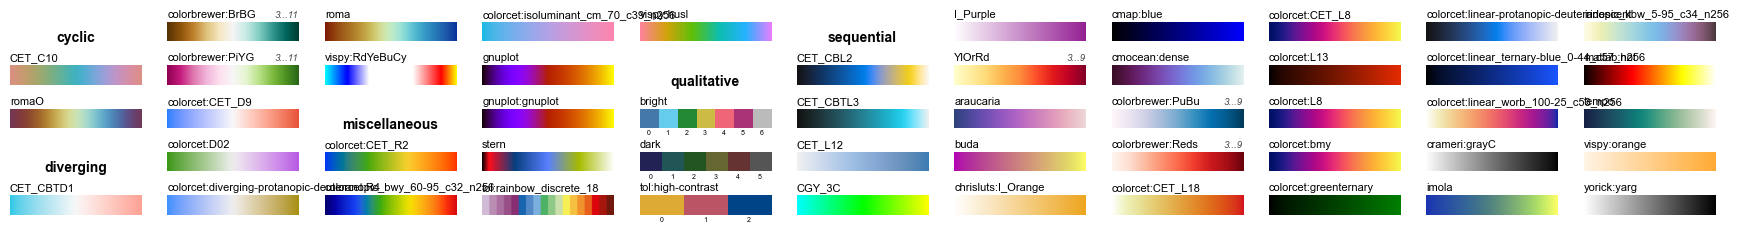

In [239]:
# old bad way of doing it. rest of section is new good way

keys = set(Colormap.catalog().keys())
subkeys = defaultdict(list)
for i in list(keys):
    for j in list(keys):
        if i != j and (m := re.match(rf"^{i}_(.+?)$", j)):
            try:
                suffix = int(m.group(1))
                subkeys[i].append(suffix)
                keys.remove(j)
            except:
                if m.group(1) == "discrete":
                    subkeys[i].append("discrete")
                    keys.remove(j)

print(subkeys.keys())

subkeys_str = {}
for k, v in subkeys.items():
    if all(isinstance(x, int) for x in v):
        v = sorted(v)
        if v == list(range(v[0], v[-1] + 1)):
            subkeys_str[k] = f"{v[0]}...{v[-1]}"
        else:
            subkeys_str[k] = ", ".join(map(str, v))
    else:
        subkeys_str[k] = ", ".join(map(str, v))
    # if k was a prefix but it not itself in the catalog
    # add an example back to the list of catalog keys
    # if k not in keys:
    #     keys.add(f"{k}_{v[-1]}")

keys = list(keys)[-50:]
keys = sorted(
    zip(range(len(keys)), keys), key=lambda x: (Colormap(x[1]).category, x[1])
)
keys = [key for _, key in keys]
n_category = len(set(Colormap(key).category for key in keys))

title_kws = dict(ha="center", va="center", fontsize=10, fontweight="bold", fontfamily="Arial")
key_kws = dict(ha="left", va="bottom", fontsize=8, fontfamily="Arial")
subkey_kws = dict(ha="right", va="bottom", color = '.3', fontsize=7, fontfamily="Arial", fontstyle="italic")
ticklabel_kws = dict(fontsize=5, fontfamily="Arial")

target_nrow = 5
min_n_cat = 2
i_row, i_col = -1, 0
key_grid = {}
prev_category = None
for key in keys:
    cmap = Colormap(key)

    if cmap.category != prev_category:
        i_row += 1 if i_row < target_nrow - min_n_cat else target_nrow - i_row
        i_col, i_row = divmod(target_nrow * i_col + i_row, target_nrow)
        prev_category = cmap.category
        key_grid[(i_row, i_col)] = {"title": cmap.category}
    
    i_row += 1
    i_col, i_row = divmod(target_nrow * i_col + i_row, target_nrow)

    key_grid[(i_row, i_col)] = key



nrow = max(r for r, c in key_grid) + 1
ncol = max(c for r, c in key_grid) + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 0.5), gridspec_kw=dict(wspace=0.2, hspace=1.25))
viz.util.axes_off(axes)
for i_row in range(nrow):
    for i_col in range(ncol):
        ax = axes[i_row, i_col]
        cell = key_grid.get((i_row, i_col), None)
        if cell is None:
            continue

        if isinstance(cell, dict):
            ax.text(0.5, 0.2, cell['title'], transform=ax.transAxes, **title_kws)
            continue

        ax.text(0, 1.15, cell, transform=ax.transAxes, **key_kws)
        cmap = Colormap(cell)
        N = None if cmap.category == "qualitative" else 1024
        img = np.array(list(cmap.iter_colors(N)))
        ax.imshow(img[None], aspect="auto")

        if cell in subkeys_str:
            ax.text(1, 1.15, subkeys_str[cell], transform=ax.transAxes, **subkey_kws)

        if cmap.category == "qualitative":
            ax.set_xticks(range(len(img)))
            ax.tick_params('both', length=0, width=0, pad=1)
            ax.set_xticklabels([f"{i}" for i in range(len(img))], **ticklabel_kws)

    

In [10]:
groups = {item.name: [item.name] for item in Colormap.catalog().values()}
is_valid_suffix = lambda s: (
    s.isnumeric()
    or s == "discrete"
    or (
        len(s.split("_")) == 2
        and s.split("_")[1].isnumeric()
        and s.split("_")[0] == "discrete"
    )
)
for k in list(groups.keys()):
    parts = k.split("_")
    prefixes = [
        ("_".join(parts[:i]), "_".join(parts[i:])) for i in range(1, len(parts))
    ]
    for prefix, suffix in prefixes:
        # proper suffixes are ints or "discrete" or
        if not is_valid_suffix(suffix):
            continue

        # shortest prefix that is already a key:
        # move any items of current group to the prefix's group
        # and delete this group
        if prefix in groups:
            groups[prefix].extend(groups.pop(k))
            break

# remove self from group
for k in list(groups.keys()):
    groups[k] = [x for x in groups[k] if x != k]

subkeys_str = {}
for k, group in groups.items():
    if not len(group):
        subkeys_str[k] = None
        continue
    
    # remove prefix from items in group
    group = [re.match(rf"^{re.escape(k)}_(.+?)$", x).group(1) for x in group]
    
    # separate into _<int> _discrete and _discrete_<int>
    int_group = sorted([int(x) for x in group if x.isnumeric()])
    discr_group = sorted(
        [int(x.split("_")[1]) for x in group if x.startswith("discrete_")]
    )
    discr_alone = "discrete" if "discrete" in group else None
    parts = []

    # convert to strings: int_group -> 3, 5, 7 or 3...7
    if len(int_group) > 0:
        if int_group == list(range(int_group[0], int_group[-1] + 1)):
            parts.append(f"{int_group[0]}...{int_group[-1]}")
        else:
            parts.append(", ".join(map(str, int_group)))
    # convert to strings: discr_group -> discrete_[3, 5, 7] or discrete_[3...7]
    if len(discr_group) > 0:
        if discr_group == list(range(discr_group[0], discr_group[-1] + 1)):
            parts.append(f"discrete_{discr_group[0]}...{discr_group[-1]}")
        else:
            parts.append(", ".join(map(str, discr_group)))
    if discr_alone is not None:
        parts.append("discrete")

    subkeys_str[k] = ", ".join(parts)

base_keys = list(subkeys_str.keys())

In [32]:
drop = [
    "cet_c1",
    "cet_c11",
    "cet_c2",
    "cet_c5",
    "cet_cbc1",
    "cet_cbc2",
    "cet_cbtc",
    "cet_cbtc2",
    "hsv",
    "cet_d8",
    "rdyebucy",
    "brg",
    "bukavu",
    "cet_r1",
    "fes",
    "fire",
    "flag",
    "glasbey",
    "gnuplot",
    "gnuplot2",
    "greenfireblue",
    "hilo",
    "ncar",
    "nipy_spectral",
    'oleron',
    'prism',
    'stern',
    'topo',
    'tab10_traffic_light',
    'afmhot',
    'blue',
    'cet_cbl1',
    'cet_cbl2',
    'cet_cbtl1',
    'cet_cbtl2',
    'cet_cetl1',
    'cet_cetl10',
    'cet_l13',
    'cet_l14',
    'cet_l15',
    'cet_l16',
    'cet_l17',
    'cet_l2',
    'cet_l3',
    'cet_l4',
    'cet_l7',
    'cgy_3c',
    'greyc',
    'greys',
    'green',
    'fake_parula',
    'hawaii',
    'heat',
    'hot',
    'i_green',
    'i_yellow',
    'incandescent',
    'iridescent',
    'light_blues',
    'magenta',
    'opf_fresh',
    'opf_orange',
    'opf_purple',
    'orange',
    'red',
    'rmb_3c',
    'speed',
    'terrain',
    'turku',
    'white',
    'yarg',
    'yellow',
    'ygc_3c',
]
base_keys = [k for k in keys if k not in drop]

In [33]:
keys = list(base_keys)
keys = sorted(
    zip(range(len(keys)), keys), key=lambda x: (Colormap(x[1]).category, x[1])
)
keys = [key for _, key in keys]
n_category = len(set(Colormap(key).category for key in keys))

target_nrow = 32
min_n_cat = 5
i_row, i_col = -1, 0
key_grid = {}
prev_category = None
for key in keys:
    cmap = Colormap(key)

    if cmap.category != prev_category:
        i_row += 1 if i_row < target_nrow - min_n_cat else target_nrow - i_row
        i_col, i_row = divmod(target_nrow * i_col + i_row, target_nrow)
        prev_category = cmap.category
        key_grid[(i_row, i_col)] = {"title": cmap.category}
    
    i_row += 1
    i_col, i_row = divmod(target_nrow * i_col + i_row, target_nrow)

    key_grid[(i_row, i_col)] = key

nrow = max(r for r, c in key_grid) + 1
ncol = max(c for r, c in key_grid) + 1
print("grid shape:", nrow, ncol)

grid shape: 32 7


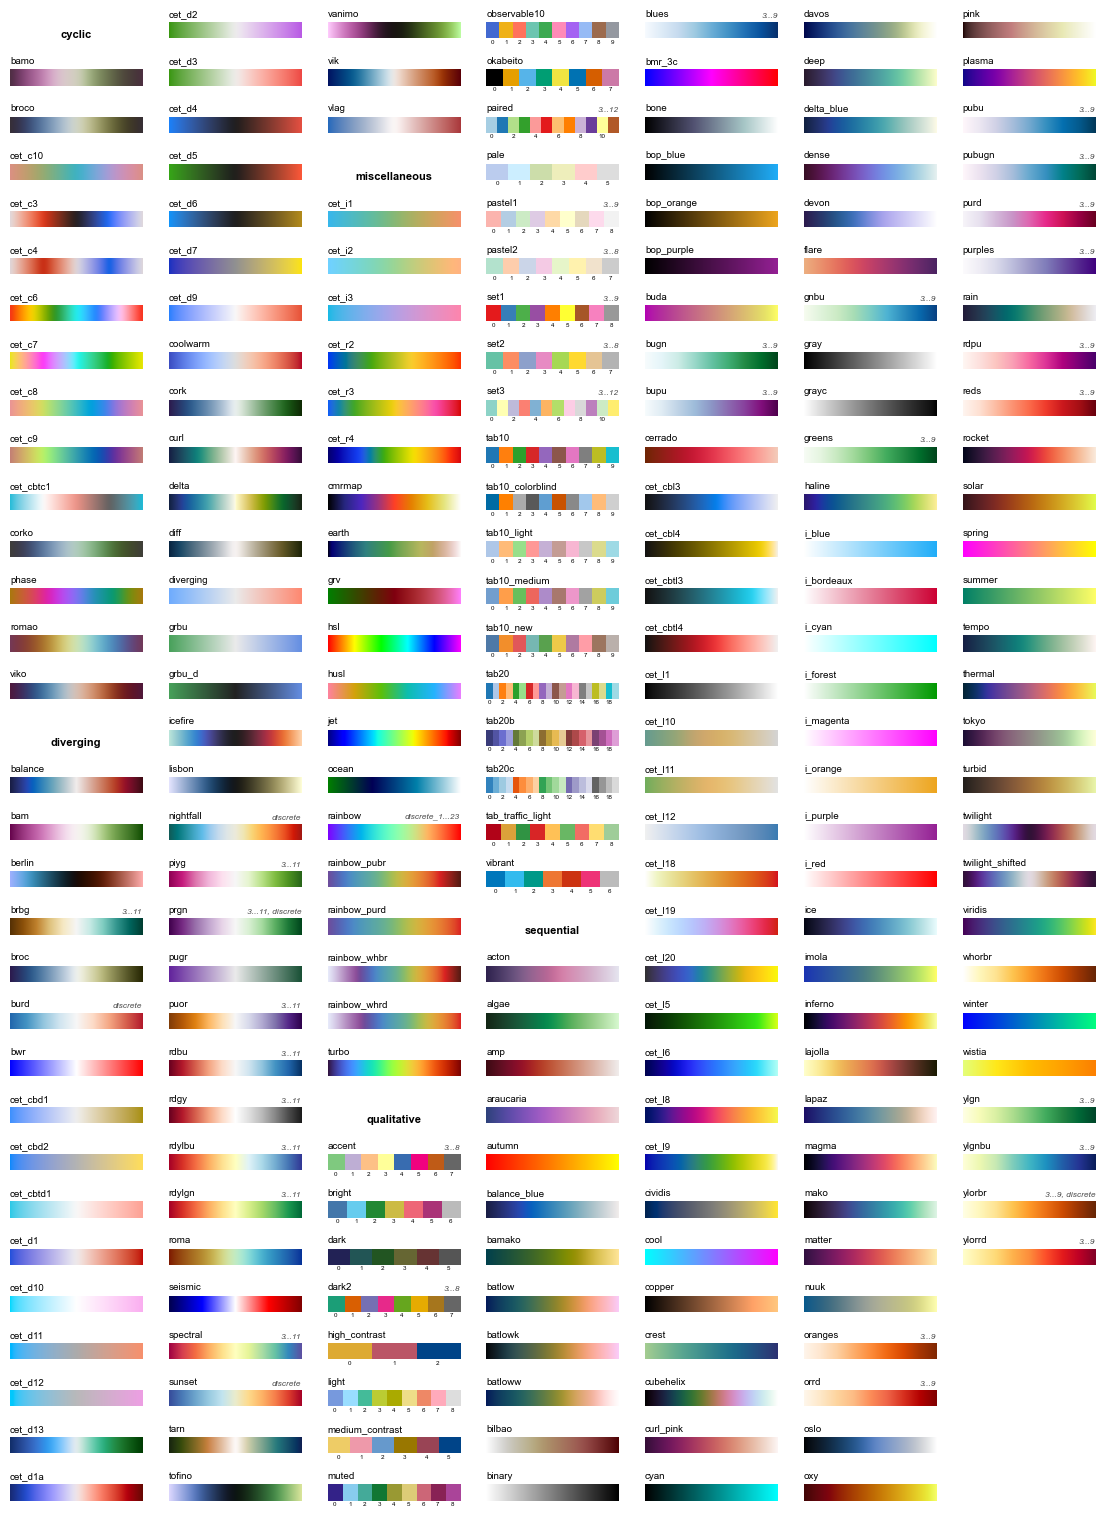

PosixPath('/Users/kaifox/Downloads/catalog.pdf')

In [38]:
title_kws = dict(ha="center", va="center", fontsize=8, fontweight="bold", fontfamily="Arial")
key_kws = dict(ha="left", va="bottom", fontsize=7, fontfamily="Arial")
subkey_kws = dict(ha="right", va="bottom", color = '.3', fontsize=6, fontfamily="Arial", fontstyle="italic")
ticklabel_kws = dict(fontsize=4.5, fontfamily="Arial")


fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 0.6), gridspec_kw=dict(wspace=0.2, hspace=1.9))
viz.util.axes_off(axes)
for i_row in range(nrow):
    for i_col in range(ncol):
        ax = axes[i_row, i_col]
        cell = key_grid.get((i_row, i_col), None)
        if cell is None:
            continue

        if isinstance(cell, dict):
            ax.text(0.5, 0.2, cell['title'], transform=ax.transAxes, **title_kws)
            continue

        ax.text(0, 1.2, cell, transform=ax.transAxes, **key_kws)
        cmap = Colormap(cell)
        N = None if cmap.category == "qualitative" else 1024
        img = np.array(list(cmap.iter_colors(N)))
        ax.imshow(img[None], aspect="auto")

        if cell in subkeys_str:
            ax.text(1, 1.2, subkeys_str[cell], transform=ax.transAxes, **subkey_kws)

        if cmap.category == "qualitative":
            if len(img) > 10:
                r = range(0, len(img), 2)
            else:
                r = range(len(img))
            ax.set_xticks(r)
            ax.tick_params('both', length=0, width=0, pad=1)
            ax.set_xticklabels([f"{i}" for i in r], **ticklabel_kws)

plotter, colors = styles.init_nb('/Users/kaifox/Downloads', style = "default", fmt = 'pdf')
plotter.finalize(fig, 'catalog', tight=False, despine=False)

### KPSN utility functions

In [112]:
# model manipulation
def lra_anchor_poses(params: LRAParams, magnitudes=90):
    """
    Parameters:
    params (LRAParams):
        Parameters used for calculating anchor poses.
    magnitudes (float, numpy.ndarray):
        The magnitude value used in calculating anchor poses. If a float, the
        same magnitude is used for all anchors. If an array, the magnitude
        for each dimension is specified separately. Not applied to the centroid
        anchor.
    
    Returns, (array, shape (n_bodies, n_dims, n_modes + 1)):
    numpy.ndarray:
        The anchor poses in the canonical pose space.
    """

    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(params.n_bodies, -1, 1)
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors

def anchor_keypoints(params: LRAParams, align_meta: dict, magnitudes=90, _inflate = None, config=None):
    """
    Calculate and return the anchor poses from a model in the original keypoint
    space. 
    
    This function computes anchor poses based on the provided parameters and
    alignment metadata, inflates the poses based on a given configuration (if
    any), and then applies inverse alignment scaling to return the poses in
    their original keypoint space. 

    Parameters:
    params, dict:
        Parameters used for calculating anchor poses.
    align_meta, dict:
        Metadata for alignment, including scaling factors.
    magnitudes, int, optional:
        The magnitude value used in calculating anchor poses. Defaults to 90.
    _inflate, function, optional:
        A custom function to inflate anchor poses. If None, a default inflation
        based on the 'features' configuration is used.
    config, dict, optional:
        Configuration dictionary that, if provided, is used to inflate the
        anchor poses using the '_inflate' function. It should contain a
        'features' key if'_inflate' is not provided. 
    
    Returns:
    numpy.ndarray, shape (n_bodies, n_anchor, n_keypt, n_spatial):
        The anchor poses in the original keypoint space after applying inverse
        alignment scaling,
    
    Note:
    This function relies on external functions `lra_anchor_poses` for
    calculating anchor poses and `alignment._inverse_align_scales` for applying
    inverse alignment scaling. It also uses a lambda function for inflation if
    '_inflate' is not explicitly provided.
    """
    if _inflate is None:
        _inflate = lambda x: features.inflate(x, config['features'])
    anchor_poses = lra_anchor_poses(params, magnitudes)  # (n_session, n_feat, n_anch)
    inflated = _inflate(anchor_poses.transpose(0, 2, 1))
    if "scale" in align_meta:
        return alignment._inverse_align_scales(
            inflated, align_meta["scale"][:, None], stacked=True
        )
    else:
        return inflated

def anchor_magnitudes(dataset: Dataset, params: LRAParams, q=0.9, canonicalized=False):
    """
    Sample the `q`th percentile in absolute value from distributions of anchor
    pose coordinates.

    dataset : Dataset
        Feature data, in canonical pose space if `canonicalized` is True.
    model : MorphModel
    params : LRAParams
    """
    if canonicalized:
        canonical = dataset.data
    else:
        canonical = model_util.apply_bodies(
            lra_model,
            params,
            dataset,
            {s: dataset.session_body_name(dataset.ref_session) for s in dataset.sessions},
        ).data

    coords = canonical @ params.modes  # (n_pts, n_modes)
    qix = jnp.argsort(abs(coords), axis=0)[int(coords.shape[0] * q)]  # argquantile
    selected_coord = coords[qix, jnp.arange(coords.shape[1])]
    return selected_coord


### 2d dataset diagnostics

In [113]:
def plot_dataset_2d(sessions, n_components, raw_data, component_ids, ax=None, titles=True, **kws):
    global colors
    component_pal = np.array(colors.cts(n_components))
    nsess = len(sessions)
    ncol = min(4, nsess)
    fig = None
    if ax is None:
        fig, ax, grid = viz.util.flat_grid(nsess, ncol, (2, 2), sharex=True, sharey=True)
    for a, s in zip(ax, sessions):
        if component_ids is not None:
            c = component_pal[component_ids[s]]
        else:
            c = 'k'
        a.scatter(*raw_data[s][..., 0].T, c=c, **{**dict(s=4, lw=0), **kws})
        if titles:
            a.set_title(s)
        a.set_aspect(1.)
    return fig, ax


def plot_canonical_steps_2d(
    plot_iters,
    project,
    model_name,
    scan_dataset
):
    # plot_iters = [0, 10, 'final']

    ckpt = methods.load_fit(project.model(model_name))
    model = instantiation.get_model(ckpt["config"])
    nsess = len(scan_dataset.sessions)
    fig, ax = plt.subplots(len(plot_iters), nsess, figsize=(2 * nsess, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]
    component_pal = np.array(colors.cts(ckpt['params'].pose.n_components))
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        step_compon_ids = get_component_assignments(
            canonicalized,
            model.pose,
            step_params.pose,
        )
        for i, sess in enumerate(scan_dataset.sessions):
            ax[row, i].scatter(
                *pad_to_2d_noise(canonicalized.get_session(sess).T),
                c=component_pal[step_compon_ids.get_session(sess)],
                s=4,
                lw=0,
            )
            if row == 0:
                ax[row, i].set_title(sess)
                if sess == scan_dataset.session_name(scan_dataset.ref_session):
                    ax[row, i].set_title(sess + ' (ref)')
                
        for a in ax[row]:
            for i_comp in range(3):
                a.scatter(
                    *pad_to_2d_zero(step_params.pose.means[i_comp, None].T),
                    c=[component_pal[i_comp]],
                    marker="s",
                    edgecolor='w',
                    lw=0.5,
                    s=30,
                    label = f"{i_comp}"
                )
            a.set_aspect("equal")
        ax[row, 0].set_xlim(-3, 3)
        ax[row, 0].set_ylim(-2, 2)
    viz.util.legend(ax[0, -1])
    fig.suptitle(model_name)
    return fig

def get_component_assignments(
    poses_dataset,
    pose_model,
    params
):
    logp = pose_model.pose_logprob(params, poses_dataset)
    return poses_dataset.update(data = jnp.argmax(logp, axis = -1))

def pad_to_2d_zero(x):
    pad = np.zeros((2 - x.shape[0],) + x.shape[1:])
    return np.concatenate([x, pad], axis=0)
def pad_to_2d_noise(x):
    pad = np.random.randn(*((2 - x.shape[0],) + x.shape[1:]))
    padded = np.concatenate([x, pad], axis=0)
    return padded

def plot_anchors_2d(
    ax,
    params,
    body_ids,
    pal=None,
    magnitudes=1,
    _inflate=lambda x: x,
    align_meta={},
    anchors=None,
    **kws,
):
    if anchors is None:
        anchors = anchor_keypoints(
            params, align_meta, magnitudes=magnitudes, _inflate=_inflate
        )
    n_anch = anchors.shape[1]
    if pal is None:
        pal = np.array(list(Colormap("tab10_new").iter_colors(n_anch)))[::-1]
    for i_anch in range(n_anch):
        for i_b, b in enumerate(body_ids):
            anch = anchors[b, i_anch]
            ax[i_b].plot(
                [anch[0]],
                [anch[1]],
                **{
                    **dict(
                        lw=0, marker='o', color=pal[i_anch], ms=5, mew=1, mec="k"
                    ),
                    **kws,
                },
            )

def plot_anchor_steps_2d(
    plot_iters,
    project,
    model_name,
    scan_dataset,
    n_components=3,
    magnitudes=1,
):
    """
    Displays true component assignments not those inferred from the model
    No inverse alignment (including scale normalization) is applied
    """

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt['config']
    model = instantiation.get_model(ckpt["config"])
    nsess = len(scan_dataset.sessions)
    fig, ax = plt.subplots(len(plot_iters), nsess, figsize=(2 * nsess, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]
    
    sessions = list(scan_dataset.sessions)
    body_ids = [scan_dataset.session_body_id(s) for s in scan_dataset.sessions]
    _inflate = lambda x: features.inflate(x, cfg['features'])
    dset_keypoints = _inflate(scan_dataset)
    dset_keypoints = {s: dset_keypoints.get_session(s) for s in sessions}
    
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")

        
        plot_dataset_2d(sessions, n_components, dset_keypoints, None, ax = ax[row])
        plot_anchors_2d(ax[row], step_params.morph, body_ids, magnitudes=magnitudes, _inflate=_inflate)

    for a in ax.ravel():
        a.set_aspect(1.)

    fig.suptitle(model_name)
    return fig, ax

### 2D dataset generation

In [114]:
def create_dataset_2d(
    sessions,
    bodies,
    session_bodies,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    transform_matrices,
    transform_biases,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Create a dictionary of keyword arguments for creating a project from a 2D
    test dataset.

    Args:
        sessions (list):
            The number of sessions in the model.
        bodies (list):
            The number of bodies in the model.
        session_bodies (dict):
            A mapping of session names to body names.
        n_frames (int):
            Number of samples to generate for each session.
        n_components (int):
            The number of components in the model.
        weights (np.ndarray, shape (n_sessions, n_components,)):
            The weights of the model, ordered as the list of session names.
        means (np.ndarray, shape (n_components, 2)):
            The means of the Gaussian componets.
        covs (np.ndarray, shape (n_components, 2, 2)):
            The covariances of the Gaussian componets.
        transform_matrices (np.ndarray, shape (n_sessions, 2, 2)):
            The transformation matrices of the affine morph to be applied to the
            data generated by the mixture model.
        transform_biases (np.ndarray, shape (n_sessions, 2)):
            The transformation biases of the affine morph.
        ref_session : str
            The reference session name or `None` to select the first session.
        keypoint_names (list):
            The names of the dimensions of the model data, or `None` to use
            integer indices (converted to strings).
        seed (int):
            The random seed to use for generating the data.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        raw_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, 2, 1)
        component_ids (dict):
            A dictionary of arrays containing the component index of each frame
            for each session.
    """

    # convert parameters to arrays
    weights = np.array(weights)
    means = np.array(means)
    covs = np.array(covs)
    transform_matrices = np.array(transform_matrices)
    transform_biases = np.array(transform_biases)

    # check sum to 1 and psd
    assert np.allclose(weights.sum(axis=1), 1)
    assert np.all(np.linalg.eigvals(covs) > 0)

    # setup
    n_bodies = len(bodies)
    n_sessions = len(sessions)
    rng = np.random.default_rng(seed)
    ref_session = ref_session or sessions[0]
    keypoint_names = keypoint_names or [str(i) for i in range(2)]
    keypoint_parents = [None] + [k for k in keypoint_names[:-1]]

    # sample component IDs
    component_ids = {
        s: rng.choice(n_components, size=n_frames, p=weights[i])
        for i, s in enumerate(sessions)
    }
    # sample gaussian noise and transform according to component IDs
    poses = {
        s: np.einsum(
            "ijk,ik->ij",
            np.linalg.cholesky(covs)[component_ids[s]],
            rng.multivariate_normal(np.zeros(2), np.eye(2), size=n_frames),
        )
        + means[component_ids[s]]
        for s in sessions
    }
    # apply affine transform
    observations = {
        s: (np.einsum("ij,aj->ai", transform_matrices[i], poses[s])
        + transform_biases[i])[..., None]
        for i, s in enumerate(sessions)
    }

    # create project config
    project_config_kws = {
        "session_names": sessions,
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": keypoint_names,
        "keypoint_parents": keypoint_parents,
    }

    return project_config_kws, observations, component_ids

### Random morph generation

In [115]:
def random_lra_morphed(
    n_bodies,
    n_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    data,
    session_names,
    seed=0,
    normalize_mode_upd=False,
):
    """
    Generate a dataset with copies of given data altered according to a random
    low-rank affine morph.

    The morph is generated by finding the PCs of `data` and then sampling
    additive gaussian noise updates the centroid and PCs. This noise is sampled
    from the first `n_noise_dims` PCs of the data.

    Args:
        n_bodies (int):
            The number of bodies in the model.
        n_dims (int):
            The number of PCs the morph should alter in the data.
        n_noise_dims (int):
            The number of PCs of the data the gaussian noise should stray over.
            (sets the number of PCs that feature reduction should keep)
        centroid_scale (float):
            The standard deviation of normal distribution from which to sample
            the centroid of the morphs.
        mode_scale (float):
            The standard deviation of normal distribution from which to sample
            the mode differences in the morphs.
        data (jax array, shape (n_frames, n_keypoints, n_dims)):
        session_names (list):
            Names for the sessions to generate.
        seed (int):
            The random seed to use for generating the data.
        normalize_mode_upd (bool):
            If True, normalize the mode updates to have deterministic length
            `mode_scale`.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        dataset_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, n_keypoints, n_spatial)
        params (LRAParams):
            The parameters of the morph.
        true_body_ids (dict):
            A dictionary mapping session names to body ids in `params`.s
    """

    # preprocess inputs
    n_bodies = len(session_names)
    rng = np.random.default_rng(seed)
    features = data.reshape(data.shape[0], -1)
    n_feats = features.shape[1]
    kp_spatial = data.shape[1:]

    # find centroid and dimensions of reference session to morph
    pca = fit_with_center(features)
    centroid = pca._center
    modes = pca._pcadata.pcs()[:n_dims].T

    # sample updates to the centroid and modes in PC space
    centroid_upds = rng.normal(
        scale=centroid_scale, size=(n_bodies, n_noise_dims)
    )
    modes_upds = rng.normal(
        scale=mode_scale, size=(n_bodies, n_noise_dims, n_dims)
    )
    if normalize_mode_upd:
        mode_norm = np.linalg.norm(modes_upds, axis=1, keepdims=True)
        modes_upds = mode_scale * modes_upds / mode_norm
    # translate noise to the full space (first pad with zeros)
    centroid_upds = np.concatenate(
        [centroid_upds, np.zeros((n_bodies, n_feats - n_noise_dims))], axis=1
    )
    modes_upds = np.concatenate(
        [modes_upds, np.zeros((n_bodies, n_feats - n_noise_dims, n_dims))],
        axis=1,
    )
    centroid_upds = pca._pcadata.from_coords(centroid_upds)
    modes_upds = pca._pcadata.from_coords(
        modes_upds.transpose(0, 2, 1)
    ).transpose(0, 2, 1)

    # create a dataset containing copies of the ref session
    # first give each session its own body to automatically assign body ids
    # then update to set the assigned body of each session to the ref body
    canonicalized = Dataset.from_arrays(
        {s: features for s in session_names},
        bodies={s: f"body-{s}" for s in session_names},
        ref_session=session_names[0],
    )
    canonicalized = canonicalized.update(
        session_meta=canonicalized.session_meta.update(
            session_bodies={
                s: f"body-{session_names[0]}" for s in session_names
            }
        ),
    )
    true_body_ids = {
        s: canonicalized.body_id(f"body-{s}") for s in session_names
    }

    # form parameters and apply them to the data
    params = morph.lowrank_affine.LRAParams(
        {
            "n_dims": n_dims,
            "n_bodies": n_bodies,
            "n_feats": n_feats,
            "ref_body": canonicalized.body_id(f"body-{session_names[0]}"),
            "prior_mode": "distance",
            "upd_var_modes": 0.0,
            "upd_var_ofs": 0.0,
            "dist_var": 0.0,
            "modes": jnp.array(modes),
            "offset": jnp.array(centroid),
            "_mode_updates": jnp.array(modes_upds),
            "_offset_updates": jnp.array(centroid_upds),
        }
    )
    observations = model_util.apply_bodies(
        morph.lowrank_affine.model,
        params,
        canonicalized,
        {s: f"body-{s}" for s in canonicalized.sessions},
    )
    dataset_keypoints = {
        s: observations.get_session(s).reshape((-1,) + kp_spatial)
        for s in session_names
    }

    # create project config
    project_config_kws = {
        "session_names": observations.sessions,
        "bodies": {
            s: observations.session_body_name(s) for s in observations.sessions
        },
        "ref_session": observations.session_name(observations.ref_session),
    }

    return (
        project_config_kws,
        dataset_keypoints,
        (params, true_body_ids),
    )

### Blscale dataset generation

In [116]:
def raw_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root

def random_scale_dict(sessions, mean = 10, std=2, seed = 0, uniform = False):
    """
    Generate a dictionary of random scale factors for each bone.

    Parameters
    ----------
    sessions : list
        List of session names or session name patterns, e.g. ["3wk_m0",
        "5wk_m*"]
    mean : float
        Mean of the uniform distribution from which to sample target lengths
    std : float
        Standard deviation of the uniform distribution from which to sample
        target lengths
    seed : int
        Random seed
    uniform : bool, tuple of float
        If False, `uniform` key in scale dict will be set to 1, otherwise should
        be a tuple of floats for the uniform distribution from which to sample
        uniform scale factors.

    Returns
    -------
    scale_dict : dict
    """
    names, parents, bones, root = raw_data_armature_meta()
    rng = np.random.default_rng(seed)
    hi, lo = mean - np.sqrt(3) * std, mean + np.sqrt(3) * std
    return {s: {
        "uniform": rng.uniform(*uniform) if uniform else 1.,
        "targets": {tuple(b): rng.normal(lo, hi) for b in bones},
    } for s in sessions}

def blscale_dataset(source_dict, scale_dict, data_dir, ref_session = None):
    """
    Create a dataset using `blscale_loader`

    Parameters
    ----------
    source_dict : str or Path
        Path to the source dictionary
    scale_dict : str or Path
        Path to the scale dictionary

    Returns
    -------
    project_config_kws : dict
        Keyword args for `loaders.arrays.setup_project_config`
    coords : dict
        Dictionary mapping session names to (unaligned) keypoint data
    scales : dict
        Dictionary mapping session names to scale bone-wise scale factors and
        uniform scale factors.
    """

    with_match = lambda test, pattern, f: f(m) if (m := re.search(pattern, test)) else None
    name_func = lambda path, *a: with_match(
        path, r"(?:/.*)+/\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy",
        lambda m: f"{m.group(1)}")

    session_names = loader.find_sessions(
        sources = source_dict,
        scales = scale_dict,
        ext = '.npy',
        name_func = name_func,
    )
    session_bodies = {s: f"body-{s}" for s in session_names}

    # skeleton without dropped keypoints
    names, parents, bones, root = raw_data_armature_meta()

    coords, _, _ = loader.external_scale(
        data_dir,
        sources=source_dict,
        scales=scale_dict,
        bones=bones,
        root_keypoint_ix=root,
        ext=".npy",
        name_func=name_func,
    )
    _, scales = loader._align_scales_sources(
        source_dict, scale_dict, ext=".npy", name_func=name_func
    )

    ref_session = list(coords.keys())[0]

    project_config_kws = {
        "session_names": coords.keys(),
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, coords, scales

## 2D fixed morph

- Sessions: "A" and "B"
- Bodies: "E" and "F"
- Pose distributions: 3 Gaussian components arranged in a triangle. One
  spherical and two with opposite correlation between the two variables. One of
  sessions "A" and "B" will have high weight on each of the
  oppositely-correlated components.
- Morphs: offset along $x$ axis with opposite skew along $y$ axis.

Each session will contain data from a 2D Gaussian mixture mapped under an affine
transform.



##### Issues
- Pose component count selection
- Calibration plots

##### Dataset and project generation

In [52]:
project_config_kws, dataset_keypoints, component_ids = create_dataset_2d(
    sessions = ["A", "B"],
    bodies = ["E", "F"],
    session_bodies = {"A": "E", "B": "F"},
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    transform_matrices = [
        [[1, 1/2], [0, 1]],
        [[1, -1/2], [0, 1]],
    ],
    transform_biases = [
        [1, 0],
        [-1, 0],
    ],
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)

In [53]:
# Create base project config to override

project_dir = Path('../projects/unit-test/2d')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [27]:
# Calibration

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(dataset, cfg)

cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["morph"]["prior_mode"] = "distance"
cfg["fit"]["n_steps"] = 100
cfg["fit"]["learning_rate"] = 1e0
cfg["fit"]["mstep"]["tol"] = None

cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=3)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=2)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

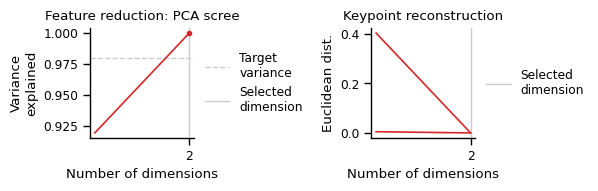

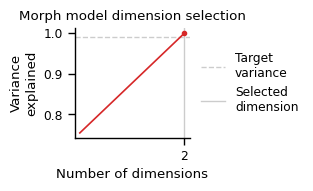

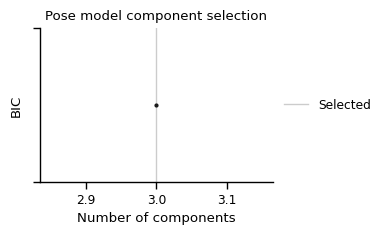

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/models/morph-prior-scan_1/plots/pose_calibration.pdf')

In [28]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [29]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 1e1]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [30]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=50, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1308.3333740234375
INFO:root:Step 50 : loss = 793.8097534179688
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/models/morph-prior-scan_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1128.7921142578125
INFO:root:Step 50 : loss = 734.4588012695312


##### Standard training diagnostics

  0%|          | 0/2 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


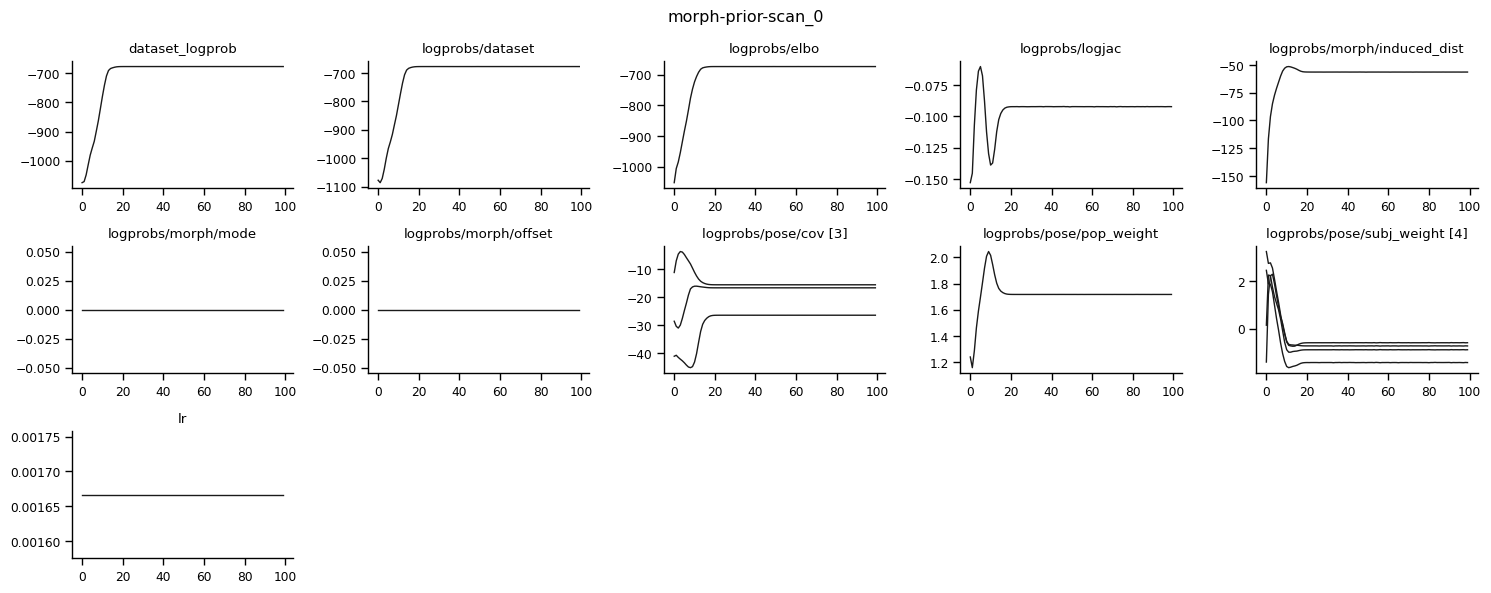

100%|██████████| 100/100 [00:00<00:00, 7064.09it/s]


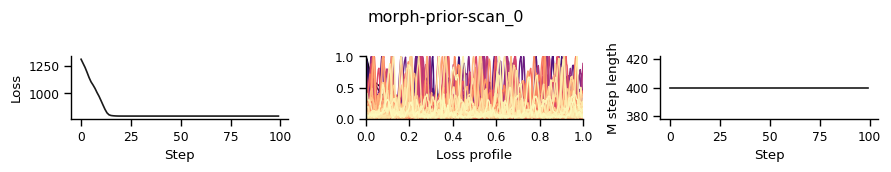

- morph


100%|██████████| 4/4 [00:00<00:00, 77.77it/s]


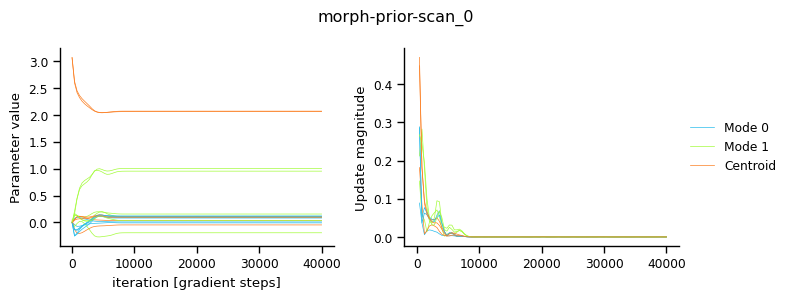

- gmm


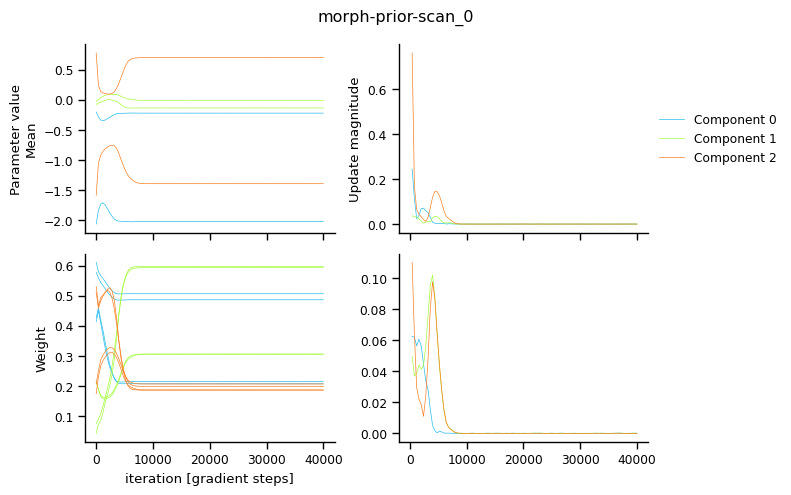

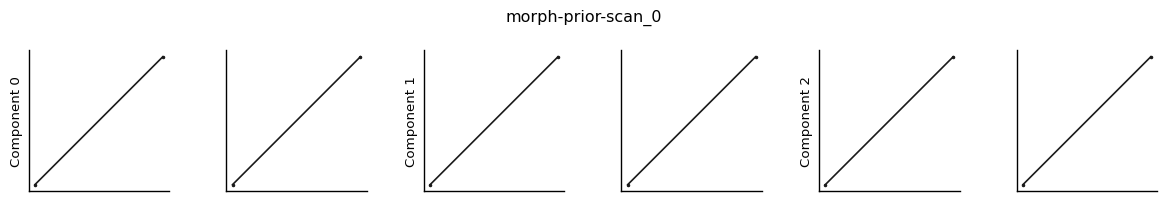

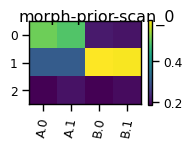

 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Plotting morph-prior-scan_1
- reports


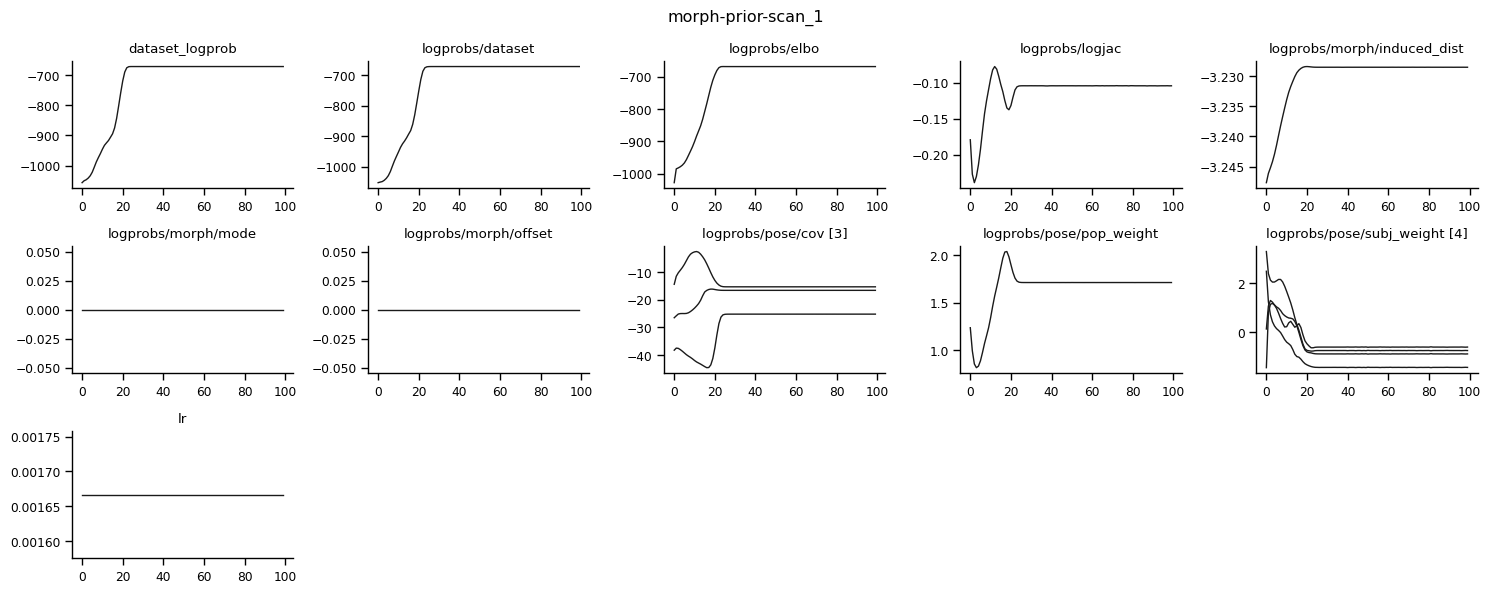

100%|██████████| 100/100 [00:00<00:00, 7222.34it/s]


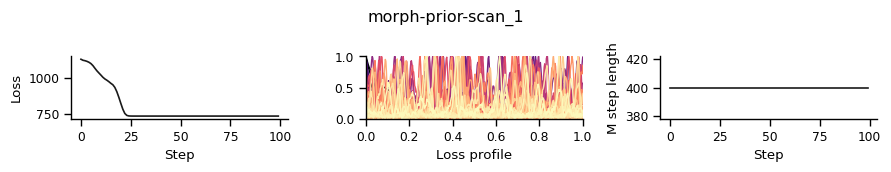

- morph


100%|██████████| 4/4 [00:00<00:00, 76.58it/s]


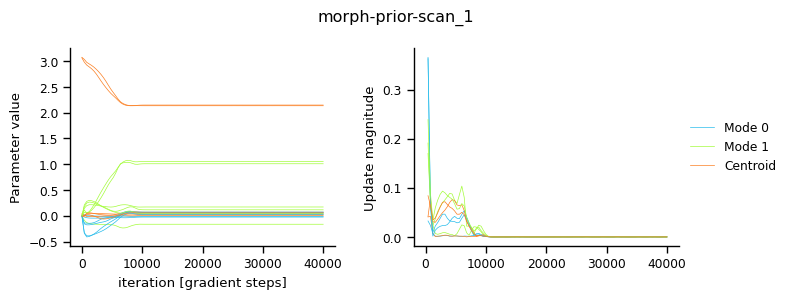

- gmm


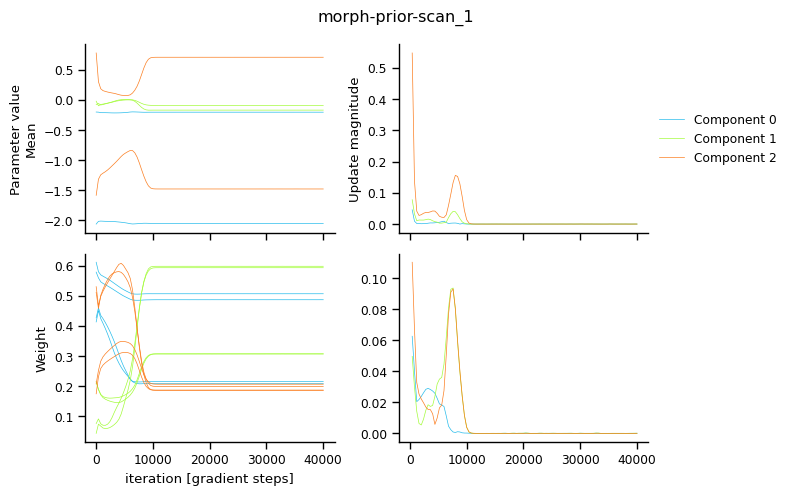

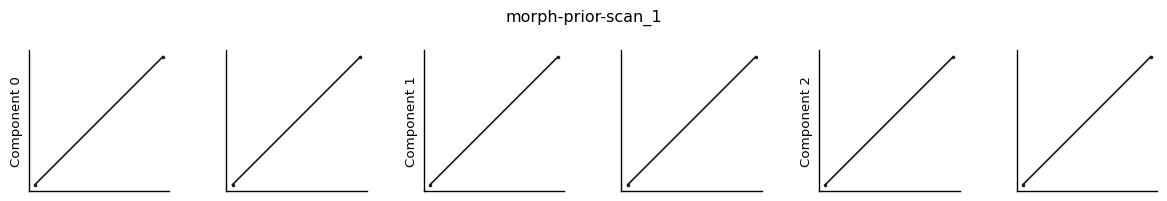

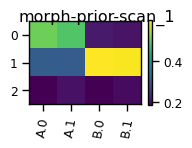

100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


In [32]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


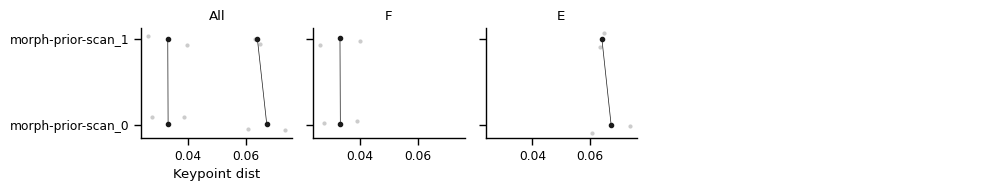

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [18]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

##### Dataset-specific results

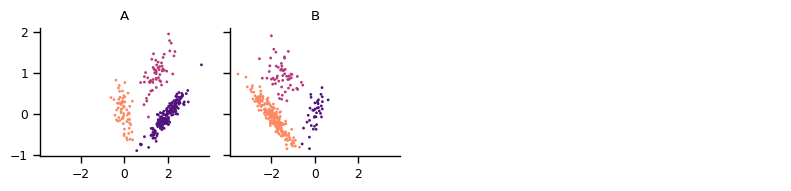

In [58]:
fig = plot_dataset_2d(["A", "B"], 3, dataset_keypoints, component_ids)
plotter.finalize(fig, None)

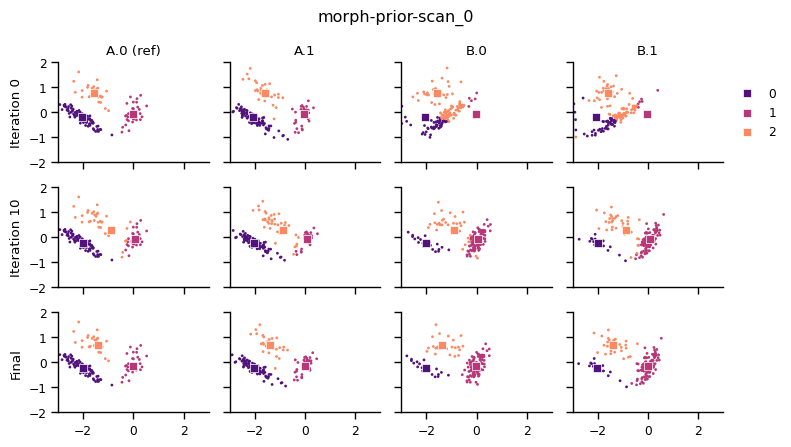

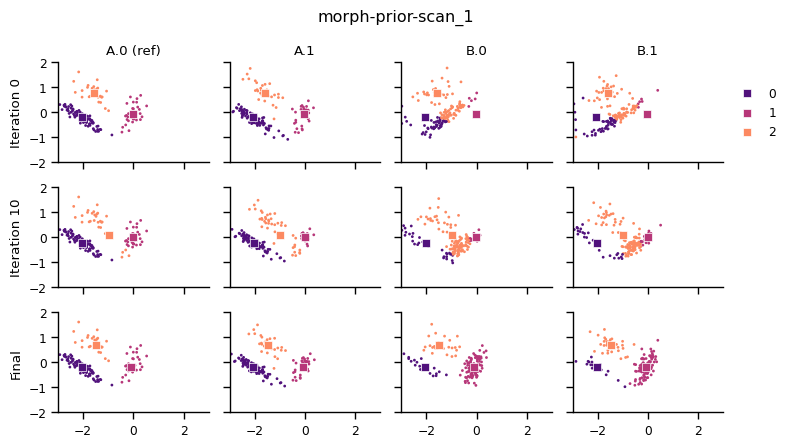

In [69]:
for model_name in models:
    fig = plot_canonical_steps_2d(
        [0, 10, 'final'],
        project,
        model_name,
        scan_dataset
    )
    plotter.finalize(fig, None)

## 2D random morph

##### Dataset generation

In [34]:
def random_lra_2d(
    sessions,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    n_morph_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Generate a 2D dataset with a random low-rank affine morph applied.

    Parameters:
    See `create_dataset_2d` and `random_lra_morphed` for details.
    """
    ref_session = sessions[0] if ref_session is None else ref_session
    project_config_2d, raw_2d, component_ids = create_dataset_2d(
        sessions=[ref_session],
        bodies=["id"],
        session_bodies={ref_session: "id"},
        n_frames=n_frames,
        n_components=n_components,
        weights=weights,
        means=means,
        covs=covs,
        transform_matrices=[[[1, 0], [0, 1]]],
        transform_biases=[[0, 0]],
        ref_session=ref_session,
        keypoint_names=keypoint_names,
        seed=seed,
    )

    project_config_lra, dataset_keypoints, (params, body_ids) = (
        random_lra_morphed(
            len(sessions),
            n_morph_dims,
            n_noise_dims,
            centroid_scale,
            mode_scale,
            raw_2d[ref_session],
            sessions,
            seed=seed + 1,
        )
    )
    project_config_lra["keypoint_names"] = project_config_2d["keypoint_names"]
    project_config_lra["keypoint_parents"] = project_config_2d[
        "keypoint_parents"
    ]

    return (
        project_config_lra,
        dataset_keypoints,
        (params, body_ids, component_ids),
    )




In [45]:
project_config_kws, dataset_keypoints, (true_params, true_body_ids, component_ids) = random_lra_2d(
    sessions = ["A", "B"],
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    n_morph_dims=1,
    n_noise_dims=1,
    centroid_scale=0.5,
    mode_scale=0.5,
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)
component_ids = {s: component_ids["A"] for s in ["A", "B"]}

In [46]:
# Create base project config to override

project_dir = Path('../projects/unit-test/2d-random')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [47]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(dataset, cfg)

cfg = features.pcs.calibrate(dataset, cfg, n_dims=1)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["pose"]["calibration"]["n_iter"] = 7
cfg["fit"]["n_steps"] = 100
cfg["fit"]["learning_rate"] = 1e0
cfg["fit"]["mstep"]["tol"] = None

cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=1)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames


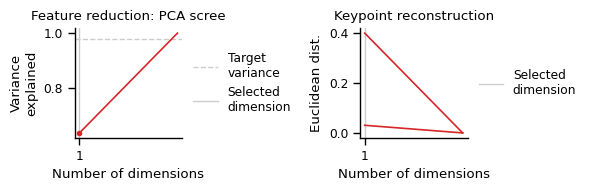

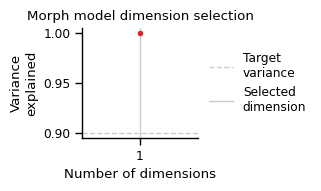

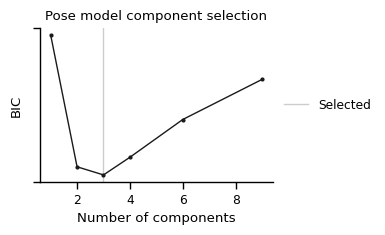

PosixPath('../projects/unit-test/2d-random/plots/pose_calibration.pdf')

In [48]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [51]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 1e1, 1e6]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [52]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d-random/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 456.3054504394531
INFO:root:Step 20 : loss = 412.4259948730469
INFO:root:Step 40 : loss = 440.765380859375
INFO:root:Step 60 : loss = 443.02520751953125
INFO:root:Step 80 : loss = 443.05743408203125
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d-random/models/morph-prior-scan_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 457.70489501953125
INFO:root:Step 20 : loss = 407.5455017089844
INF

##### Standard training diagnostics

Reloading 'kpsn.viz.model'.


  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


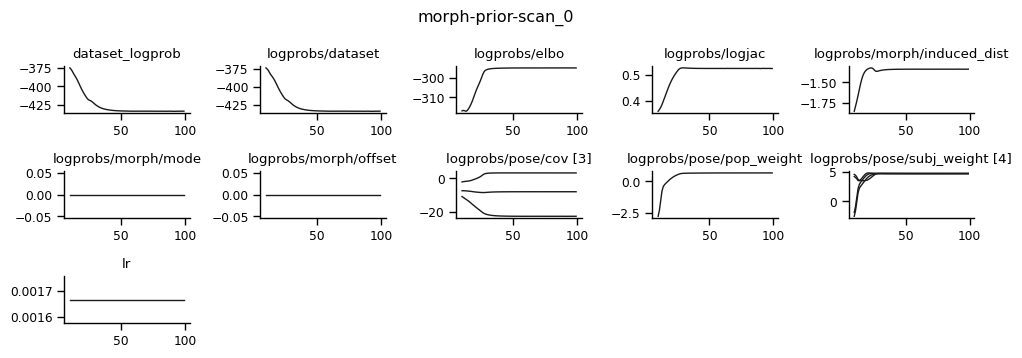

100%|██████████| 100/100 [00:00<00:00, 6412.33it/s]


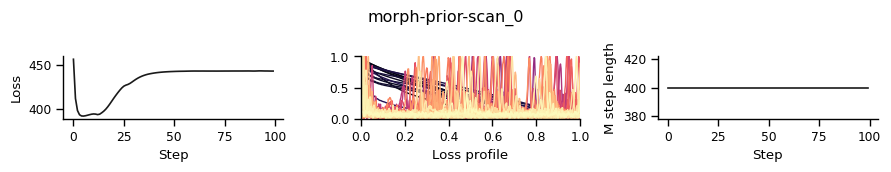

- morph


100%|██████████| 4/4 [00:00<00:00, 136.12it/s]


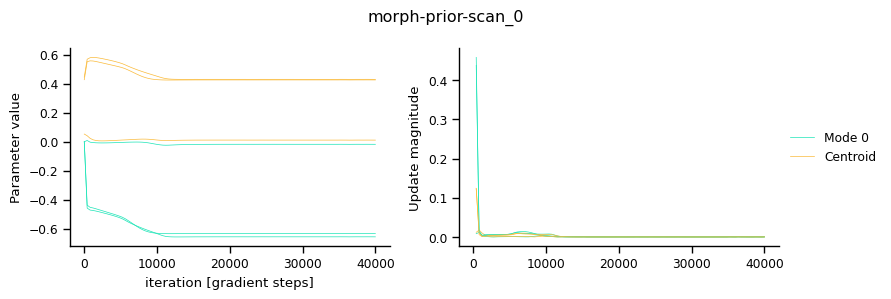

- gmm


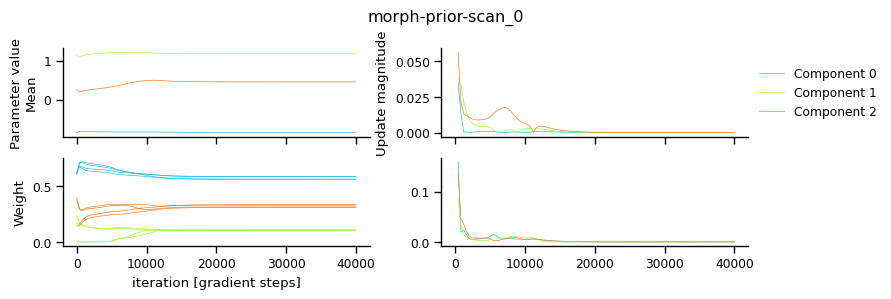

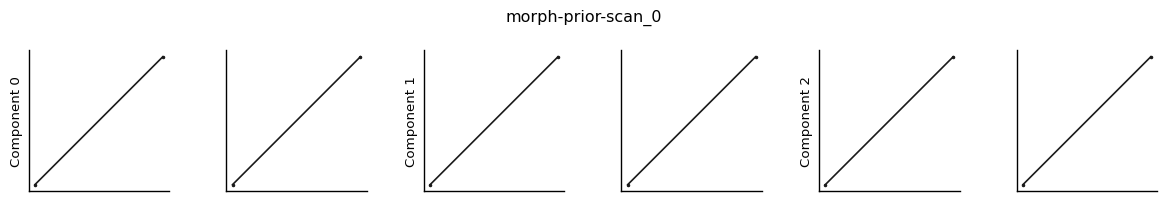

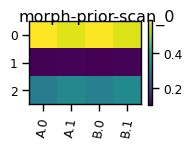

 33%|███▎      | 1/3 [00:01<00:03,  1.82s/it]

Plotting morph-prior-scan_1
- reports


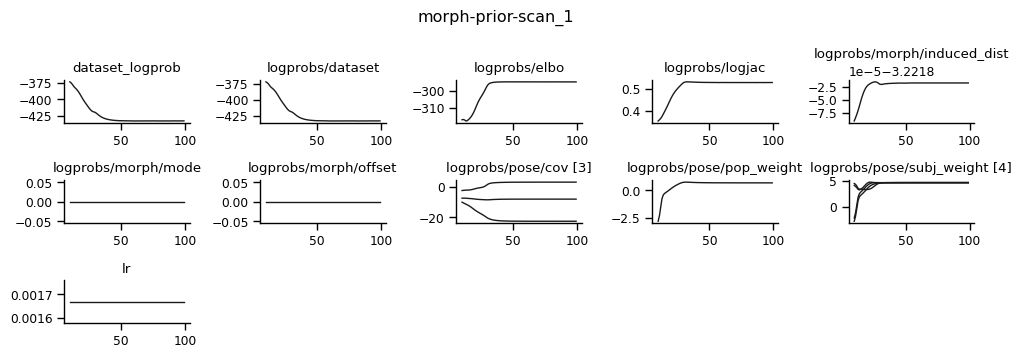

100%|██████████| 100/100 [00:00<00:00, 5947.34it/s]


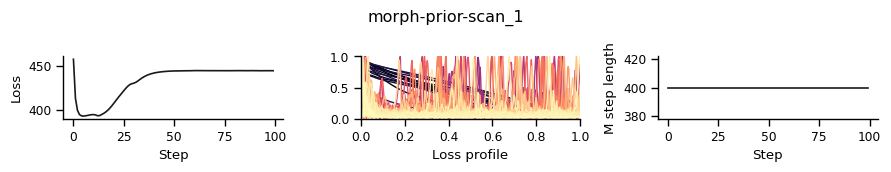

- morph


100%|██████████| 4/4 [00:00<00:00, 149.68it/s]


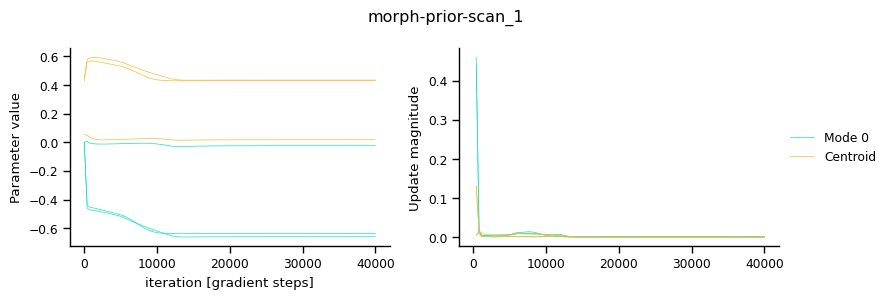

- gmm


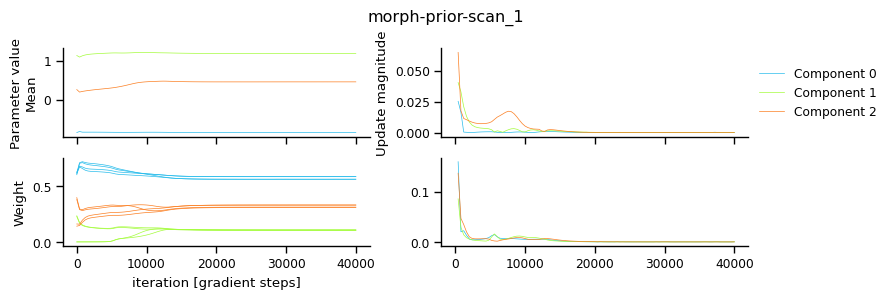

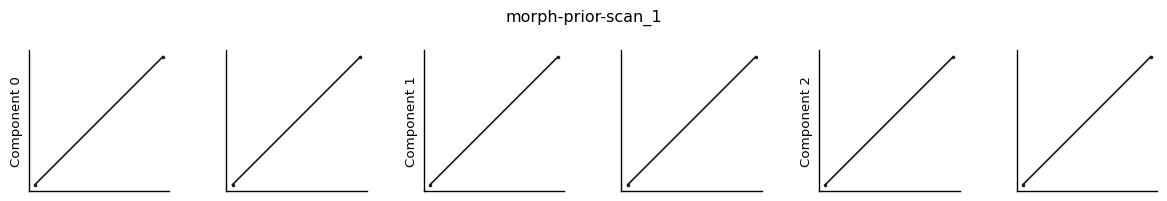

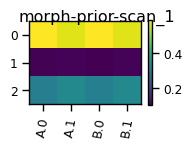

 67%|██████▋   | 2/3 [00:03<00:01,  1.64s/it]

Plotting morph-prior-scan_2
- reports


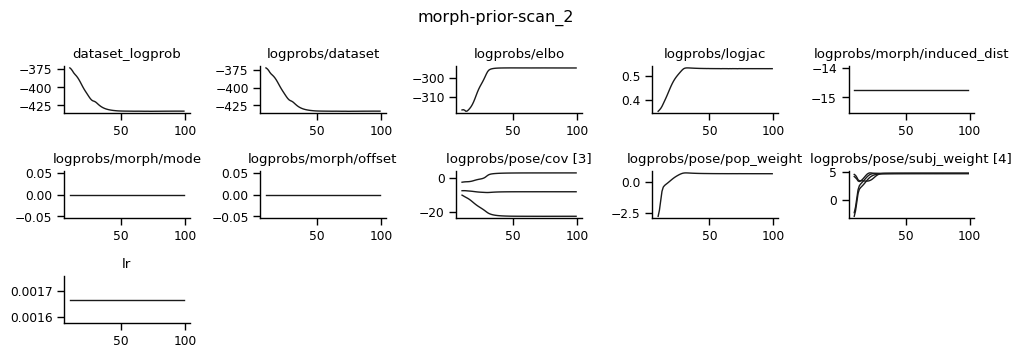

100%|██████████| 100/100 [00:00<00:00, 5417.39it/s]


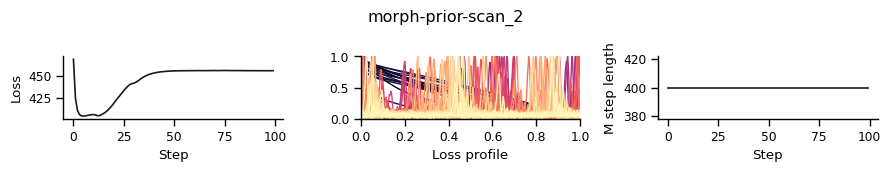

- morph


100%|██████████| 4/4 [00:00<00:00, 57.84it/s]


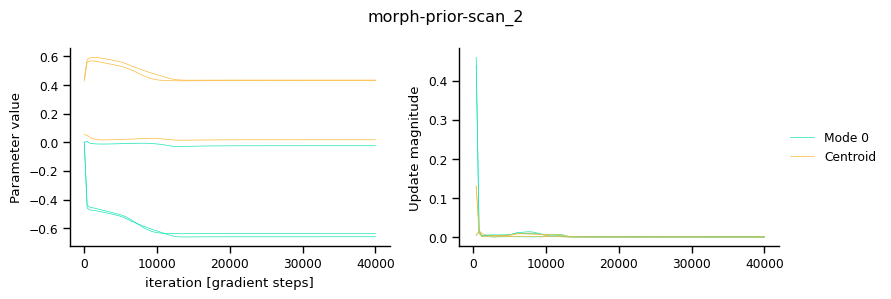

- gmm


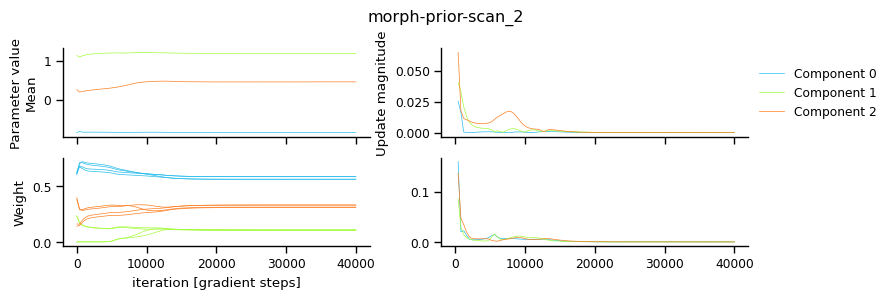

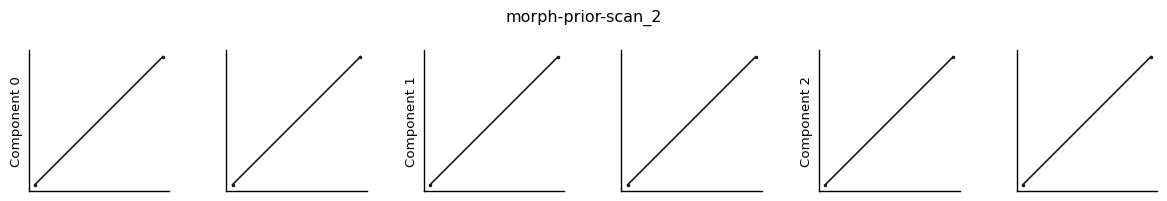

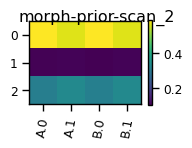

100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


In [64]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=10, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

##### Dataset-specific results

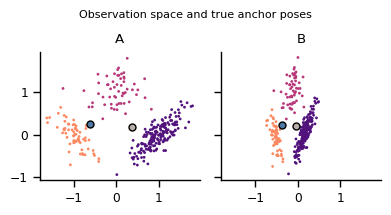

In [60]:
fig, ax = plot_dataset_2d(["A", "B"], 3, dataset_keypoints, component_ids)

plot_anchors_2d(ax, true_params, [true_body_ids[s] for s in "AB"], magnitudes=1)
fig.suptitle("Observation space and true anchor poses", fontsize=8)

plotter.finalize(fig, None)

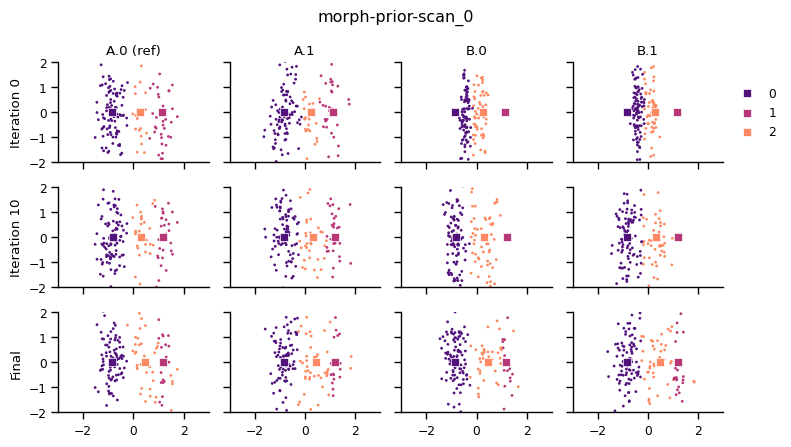

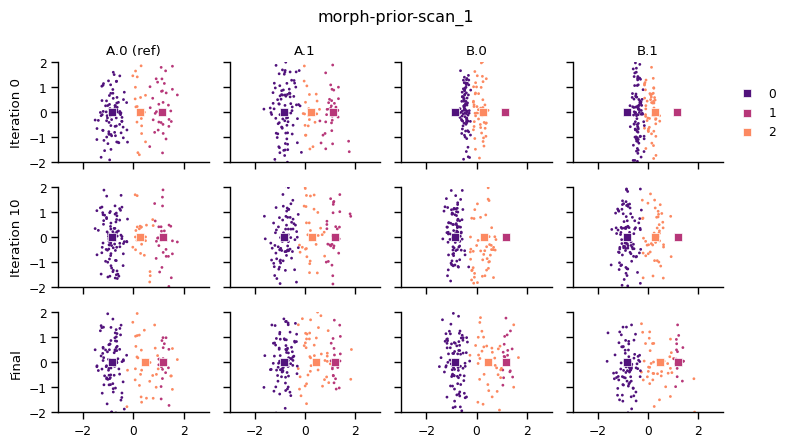

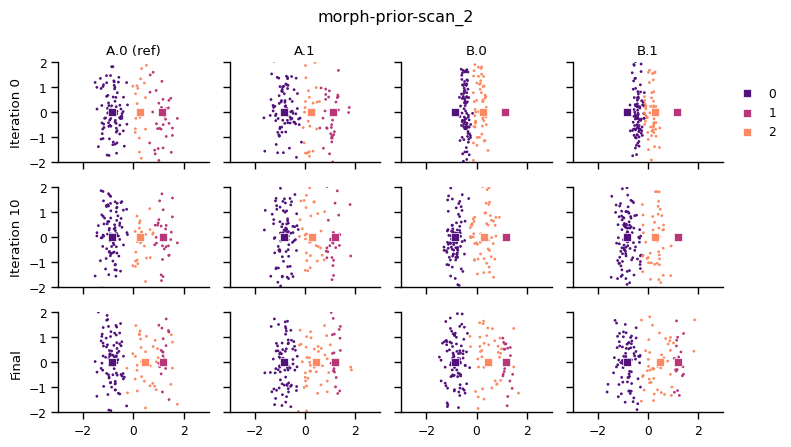

In [55]:
for model_name in models:
    fig = plot_canonical_steps_2d(
        [0, 10, 'final'],
        project,
        model_name,
        scan_dataset
    )
    plotter.finalize(fig, None)

Reference session:
(pcs) PCAData(n_fit=300, s=array([14.887394,  8.870147], dtype=float32), v=Array([[-0.99708015,  0.07636227],
       [ 0.07636227,  0.99708015]], dtype=float32))
(center) [0.3758241  0.17683718]
Full dataset:
(pcs)  PCAData(n_fit=600, s=array([16.548567, 12.544283], dtype=float32), v=Array([[-0.99708015,  0.07636223],
       [ 0.07636223,  0.99708015]], dtype=float32))
(center) [0.17101929 0.19252239]


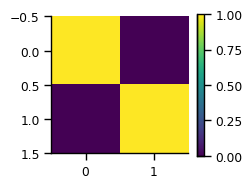

In [56]:
# Validate PCs
ref_pcs = fit_with_center(
    dataset_keypoints["A"].reshape(dataset_keypoints["A"].shape[0], -1)
)
print("Reference session:\n(pcs)", ref_pcs._pcadata)
print("(center)", ref_pcs._center)

cfg = config.load_model_config(project.base_model_config())
print(
    "Full dataset:\n(pcs) ",
    ckpt["config"]["features"]["calibration_data"]["pcs"],
)
print("(center)", ckpt["config"]["features"]["calibration_data"]["center"])


# shape: (ref_pc, dataset_pc)
pc_cos = (
    ref_pcs._pcadata.pcs()[:, None]
    * cfg["features"]["calibration_data"]["pcs"].pcs()[None]
).sum(axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))
_ = ax.imshow(pc_cos)
fig.colorbar(_, ax = ax)
plotter.finalize(fig, None)

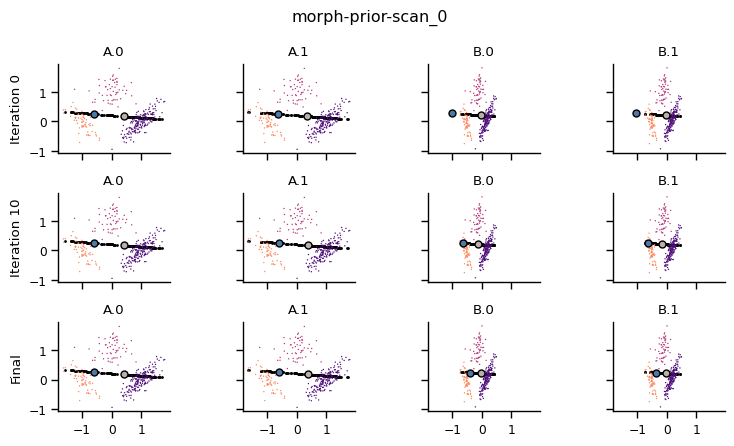

In [61]:
# Full session data in color
# Inflated data from `scan_dataset` in black
# Anchor poses large colored dots

for model_name in models:

    fig, ax = plot_anchor_steps_2d(
        [0, 10, "final"],
        project,
        model_name,
        scan_dataset,
    )
    for row in range(len(ax)):
        plot_dataset_2d(
            ["A", "A", "B", "B"],
            3,
            dataset_keypoints,
            component_ids,
            ax=ax[row],
            s=1,
            titles=False,
        )
    plotter.finalize(fig, None)
    break

## Load mouse data

The following two projects use keypoints from Mo's dataset.

In [3]:
data_root = '../../../data_explore/data'

# Create mapping of session names (ie 3wk_m0) to keypoint data paths

modata_npy_name_func = (lambda path, *a:
    match.group(1) if ((match := re.search(r"\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy", path)) is not None) else None)
session_paths = dict(filter(lambda x: x[0] is not None, [(modata_npy_name_func(m), str(Path(data_root) / m)) for m in os.listdir(data_root)]))
# throw out 9-12 week
session_ages = {s: s.split('_')[0].strip('wk') for s in session_paths}
ages = set(session_ages.values())
ages = list(filter(lambda x: x not in ["5", "7", "9", "12", "24", "52", "72"], ages))
session_paths = {s: p for s, p in session_paths.items() if session_ages[s] in ages}
session_bodies = {s: f'body-{session_ages[s]}wk' for s in session_paths}
ref_age = "3"

age_dates =  {
    "3" : "10_11_22",
    "5" : "10_24_22",
    "7" : "10_24_22",
    "24": "11_03_22",
    "52" : "11_03_22",
    "72" : "10_14_22",
}

print("sessions:", session_paths.keys())

raw_keypoints = {
    s: np.load(p) for s, p in session_paths.items()
}

sessions: dict_keys(['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'])


## Random morph on mouse-shaped data

Create morphed a copy of session `3wk_m0` altered my a random low-rank affine
morph with the first PC of `3wk_m0` moved to a new vector arrived at by adding
Gaussian noise.

As above, the Gaussian noise is limited to the first principal component of the
data.

To make fitting easy:
- 1 PC morph function (don't have to learn no-op on other dimensions)
- 1 component GMM (no pose distribution differences to learn)

##### Dataset and project config generation

In [26]:
session = "3wk_m0"
aligned_keypoints, align_inv = alignment.sagittal._align(
    Dataset.from_arrays(
        {session: raw_keypoints[session]},
        {session: "body"},
        session,
        {"keypoint_ids": {"hips": 2, "head": 5}},
    ),
    config={"origin": "hips", "anterior": "head", "rescale": False},
)
use_keypts = [
    'shldr', 'back', 'hips', 't_base', 'head',
    'l_ear', 'r_ear', 'nose',
]
ref_session = loaders._extract_keypoints_from_array(
    aligned_keypoints.get_session(session),
    keypoint_names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
    use_keypoints=use_keypts,
    subsample=None,
    invert_axes=None,
    subsample_to=1000,
)

project_config_kws, dataset_keypoints, (true_params, true_body_ids) = random_lra_morphed(
    n_bodies=2,
    n_dims=1,
    n_noise_dims=1,
    centroid_scale=0,
    mode_scale=5e-1,
    data=jnp.array(ref_session),
    session_names=["A", "B"],
    seed=0,
    normalize_mode_upd=True,
)

In [27]:
# Create base project config to override

project_dir = Path('../projects/unit-test/in-domain-morph')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    keypoint_names = use_keypts,
    keypoint_parents = [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head'],
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [29]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(
    dataset, cfg, #origin="hips", anterior="head"
)

cfg = features.pcs.calibrate(dataset, cfg, n_dims=1)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["pose"]["calibration"]["n_iter"] = 7
cfg["fit"]["n_steps"] = 80
cfg["fit"]["learning_rate"] = 1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
# ground truth morph has only one mode
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=1)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

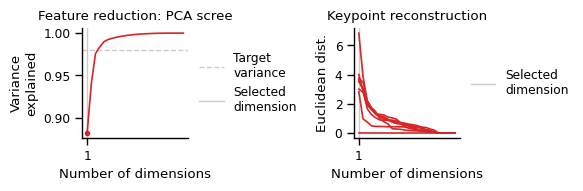

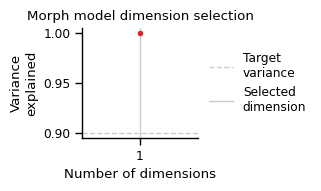

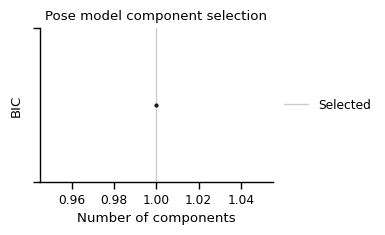

PosixPath('../projects/unit-test/in-domain-morph/plots/pose_calibration.pdf')

In [30]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [31]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan-pl1", {
    'morph.dist_var': [1e-1, 1e1, 1e6]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan-pl1", return_session_inv=True)

In [32]:
scans.run_scan(project, "morph-prior-scan-pl1", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/in-domain-morph/models/morph-prior-scan-pl1_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:1 -> 0.0005
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 120142.8359375
INFO:root:Step 20 : loss = 22132.740234375
INFO:root:Step 40 : loss = 10083.3623046875
INFO:root:Step 60 : loss = 9936.5546875
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/in-domain-morph/models/morph-prior-scan-pl1_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:1 -> 0.0005
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 9881.84765625
INFO:root:Step 20 : loss = 9867.87890625
INFO:root:Step 40 : loss = 9866.2490234375
INFO:root:Step 60 : loss = 9866.24902343

##### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan-pl1_0
- reports


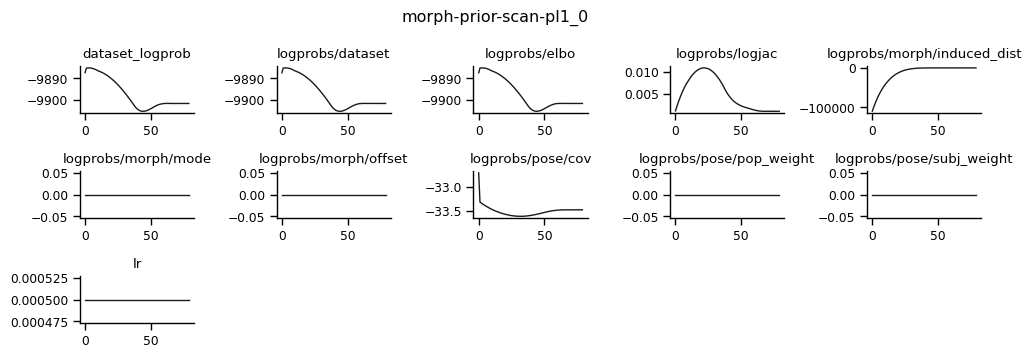

100%|██████████| 80/80 [00:00<00:00, 7214.92it/s]


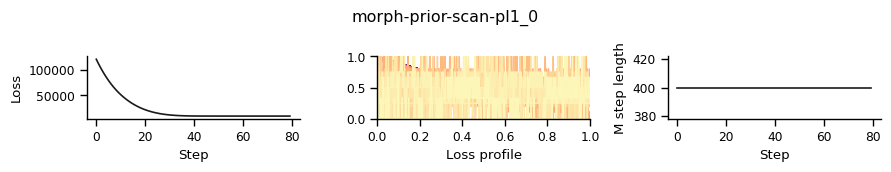

- morph


100%|██████████| 4/4 [00:00<00:00, 212.39it/s]


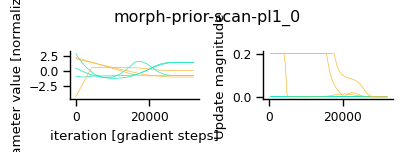

- gmm


100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


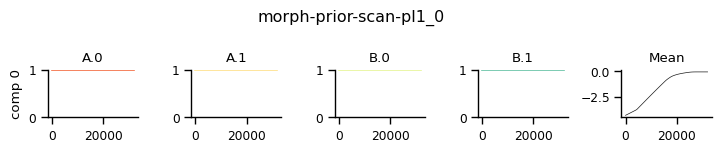

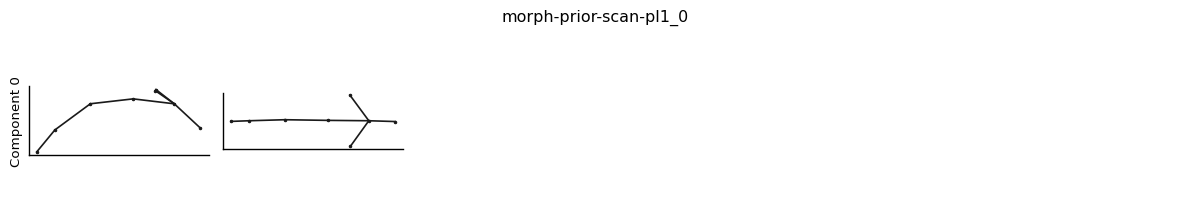

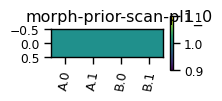

 33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

Plotting morph-prior-scan-pl1_1
- reports


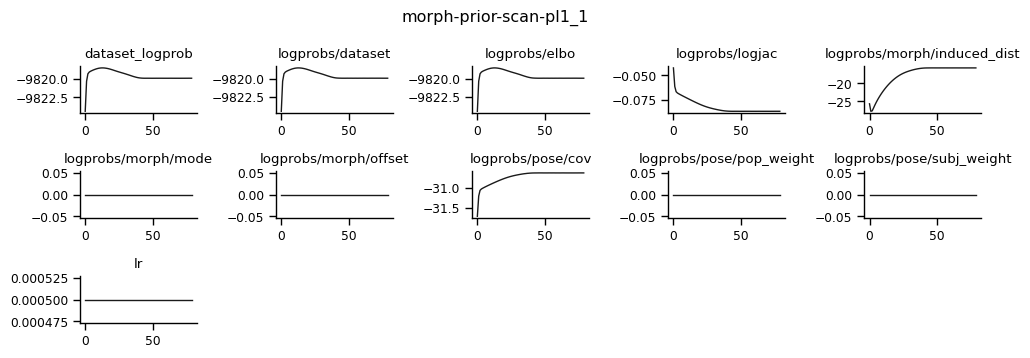

100%|██████████| 80/80 [00:00<00:00, 6891.73it/s]


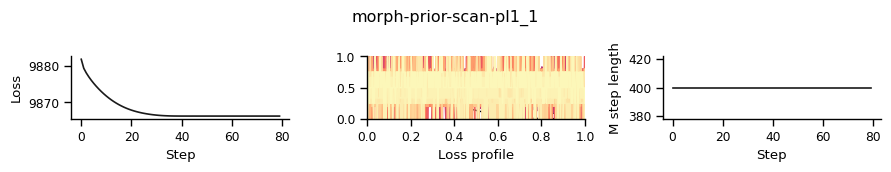

- morph


100%|██████████| 4/4 [00:00<00:00, 193.34it/s]


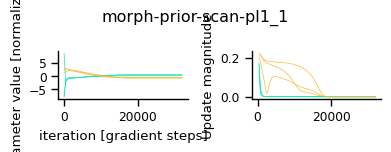

- gmm


100%|██████████| 1/1 [00:00<00:00, 94.25it/s]


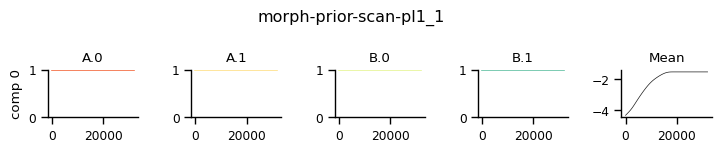

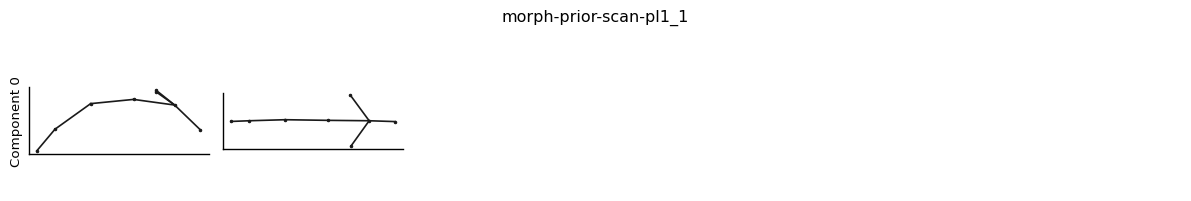

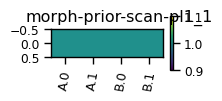

 67%|██████▋   | 2/3 [00:03<00:01,  1.49s/it]

Plotting morph-prior-scan-pl1_2
- reports


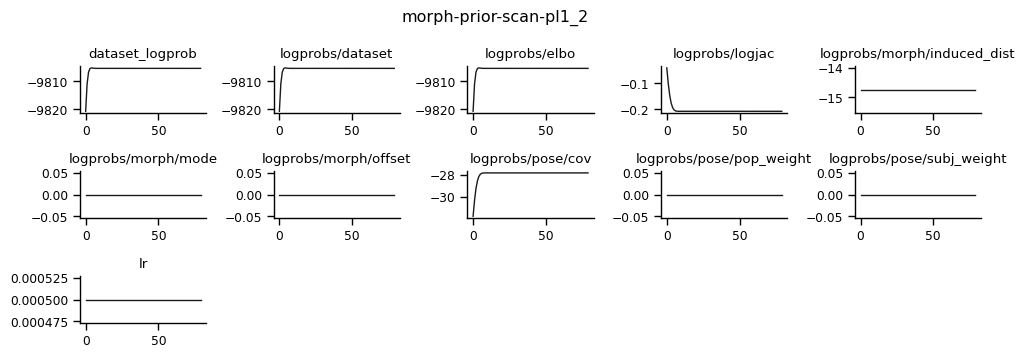

100%|██████████| 80/80 [00:00<00:00, 7031.23it/s]


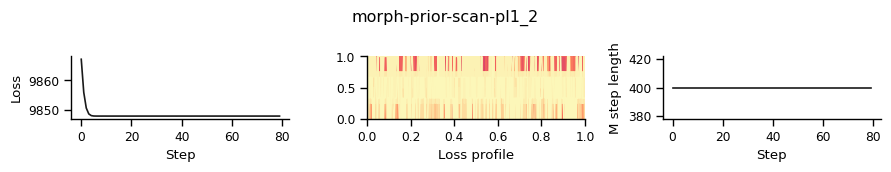

- morph


100%|██████████| 4/4 [00:00<00:00, 219.66it/s]


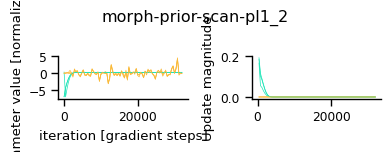

- gmm


100%|██████████| 1/1 [00:00<00:00, 105.24it/s]


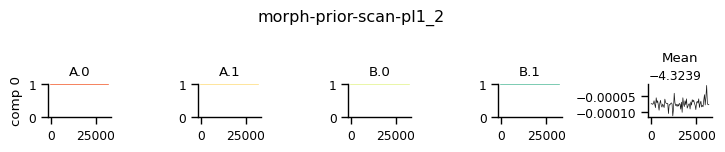

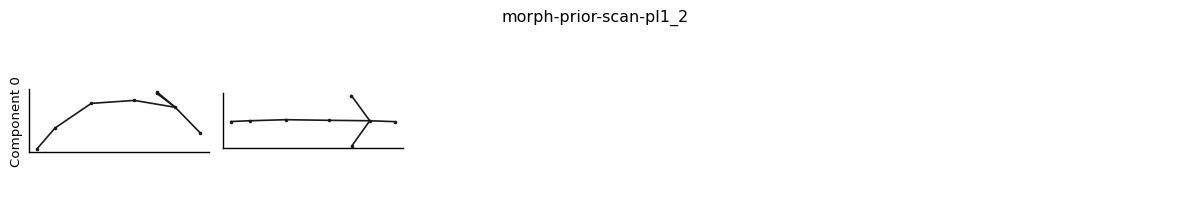

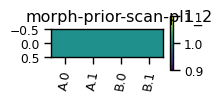

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


In [33]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

##### Dataset specific results

###### 1
Dataset visualization

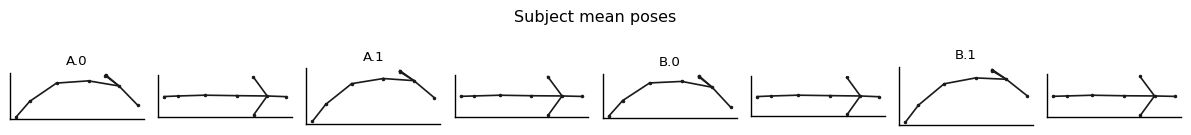

In [34]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

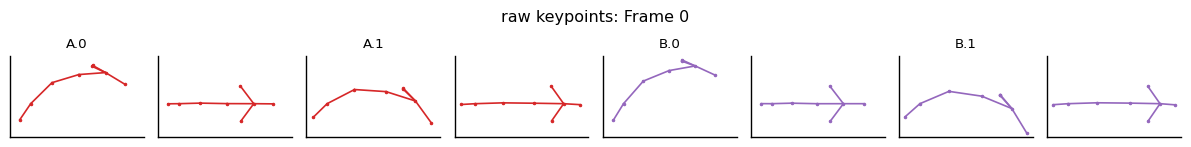

In [35]:
fig, ax = plt.subplots(1, 8, figsize=(12, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
for i, sess in enumerate(scan_dataset.sessions):
    root_sess = sess.split('.')[0]
    viz.util.plot_mouse_views(
        ax[2*i:2*(i+1)],
        inflated.get_session(sess)[0],
        arms, color = session_pal[root_sess], label=root_sess,
    )
    ax[2*i].set_title(sess)
fig.suptitle(f"raw keypoints: Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 2

PC respect validation (requires project calibration)


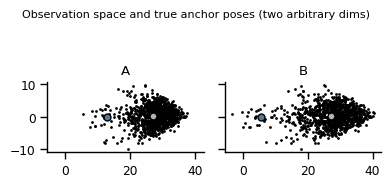

In [248]:
cfg = config.load_model_config(project.base_model_config())
anchors_2d = anchor_keypoints(
    true_params, {}, magnitudes=90, _inflate = lambda x: x
)
anchors_2d = anchors_2d.reshape(*(anchors_2d.shape[:2] + (len(use_keypts), 3)))
keypoints_2d = {s: k[:, [0, 1], [0, 1], None] for s, k in dataset_keypoints.items()}
anchors_2d = anchors_2d[:, :, [0, 1], [0, 1]]

fig, ax = plot_dataset_2d(["A", "B"], 0, keypoints_2d, None)
plot_anchors_2d(ax, None, [true_body_ids[s] for s in "AB"], anchors=anchors_2d)
fig.suptitle("Observation space and true anchor poses (two arbitrary dims)", fontsize=8)
plotter.finalize(fig, None)

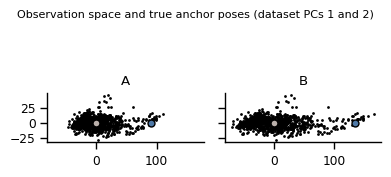

In [249]:
cfg = config.load_model_config(project.base_model_config())
dataset_pcs = CenteredPCA(cfg["features"]["calibration_data"]["center"], cfg["features"]["calibration_data"]["pcs"])
_reduce = lambda x: dataset_pcs.coords(x.reshape(x.shape[:-1] + (-1,))).reshape(x.shape)
anchors_2d = anchor_keypoints(
    true_params, {}, magnitudes=90, _inflate = lambda x: x
)
keypoints_2d = {s: _reduce(k.reshape(k.shape[0], -1))[:, [0, 1], None] for s, k in dataset_keypoints.items()}
anchors_2d = _reduce(anchors_2d)[..., [0, 1]]

fig, ax = plot_dataset_2d(["A", "B"], 0, keypoints_2d, None)
# fig, ax = plt.subplots(1, 2, figsize = (4, 2), sharex=True, sharey=True)
plot_anchors_2d(ax, None, [true_body_ids[s] for s in "AB"], anchors=anchors_2d)
fig.suptitle("Observation space and true anchor poses (dataset PCs 1 and 2)", fontsize=8)
plotter.finalize(fig, None)

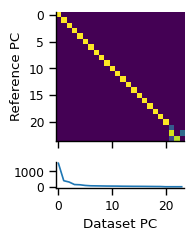

In [250]:
# Validate PCs
# PCs of reference session (A)
ref_pcs = fit_with_center(
    dataset_keypoints["A"].reshape(dataset_keypoints["A"].shape[0], -1)
)._pcadata

# PCs of full dataset
dataset_pcs = cfg["features"]["calibration_data"]["pcs"]
# _features = [k.reshape(k.shape[0], -1) for k in dataset_keypoints.values()]
# dataset_pcs = fit_with_center(
#     np.concatenate(_features, axis=0)
# )._pcadata

# shape: (ref_pc, dataset_pc)
pc_cos = (
    ref_pcs.pcs()[:, None]
    * dataset_pcs.pcs()[None]
).sum(axis=-1)

# plot cosine similarity between PC sets
fig, ax = plt.subplots(2, 1, figsize=(2,2.5), height_ratios=[5, 1], sharex=True)
_ = ax[0].imshow(pc_cos, vmin=0, vmax=1)
ax[1].plot(dataset_pcs.s)
ax[1].set_xlabel('Dataset PC')
ax[0].set_ylabel('Reference PC')
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

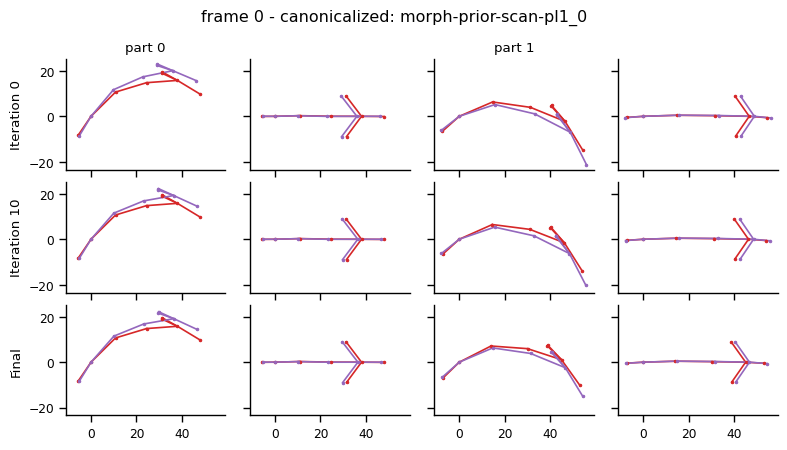

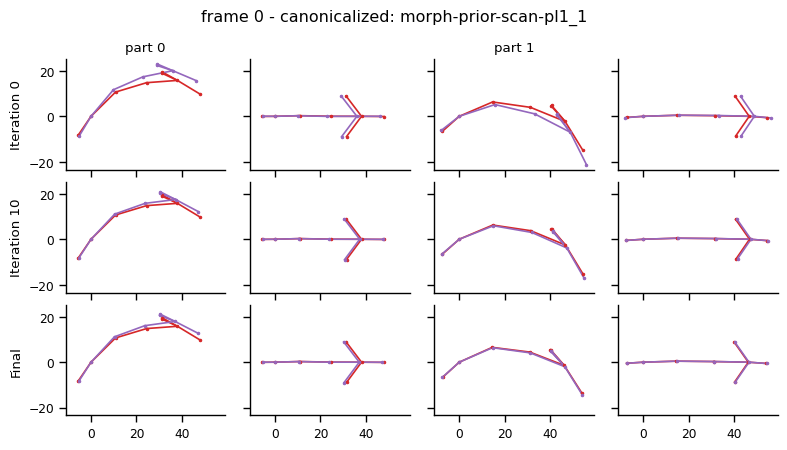

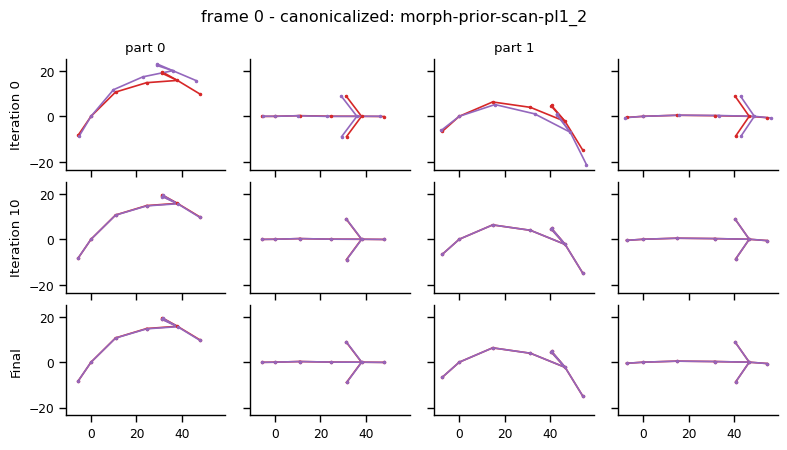

In [36]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in "AB":
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


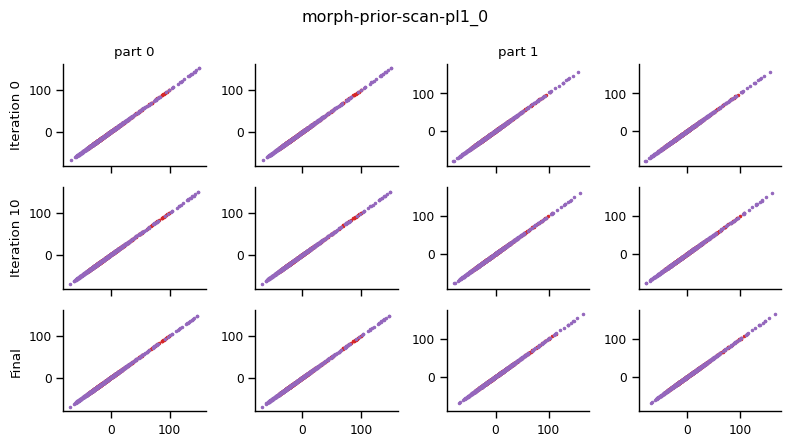

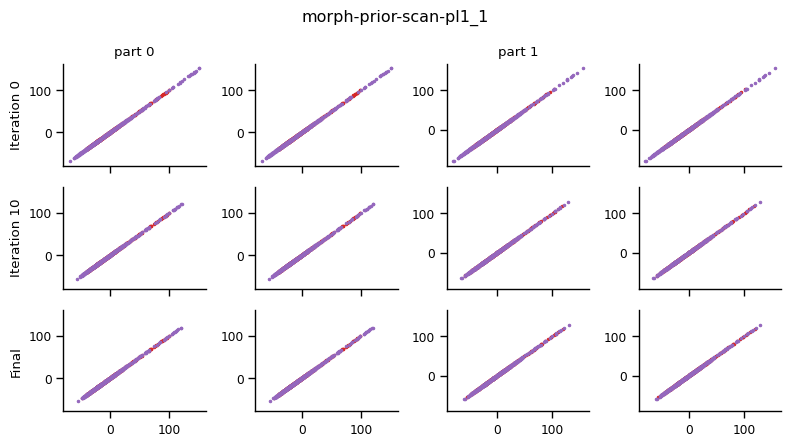

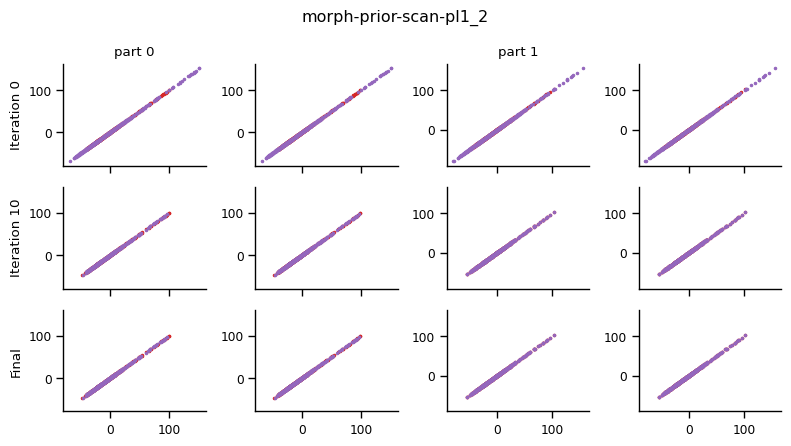

In [37]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex='col', sharey = 'col')
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in "AB":
                sess = f"{root_sess}.{part}"
                
                ax[row, 2 * col].scatter(
                    *canonicalized.get_session(sess)[:, [0, 1]].T,
                    color = session_pal[root_sess],
                    label=root_sess,
                    s = 3,
                )
                ax[row, 2 * col + 1].scatter(
                    *canonicalized.get_session(sess)[:, [2, 3]].T,
                    color = session_pal[root_sess],
                    label=root_sess,
                    s = 3,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(model_name)
    plotter.finalize(fig, None)

## Random morph with >1 accessible dimensions

Dataset: Copy of `3wk_m0` data with one dimension morphed with mode / centroid
updates chosen from first 5 PCs.

##### Dataset and project config generation

In [39]:
session = "3wk_m0"
aligned_keypoints, align_inv = alignment.sagittal._align(
    Dataset.from_arrays(
        {session: raw_keypoints[session]},
        {session: "body"},
        session,
        {"keypoint_ids": {"hips": 2, "head": 5}},
    ),
    config={"origin": "hips", "anterior": "head", "rescale": False},
)
use_keypts = [
    'shldr', 'back', 'hips', 't_base', 'head',
    'l_ear', 'r_ear', 'nose',
]
ref_session = loaders._extract_keypoints_from_array(
    aligned_keypoints.get_session(session),
    keypoint_names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
    use_keypoints=use_keypts,
    subsample=None,
    invert_axes=None,
    subsample_to=1000,
)

project_config_kws, dataset_keypoints, (true_params, true_body_ids) = random_lra_morphed(
    n_bodies=2,
    n_dims=1,
    n_noise_dims=5,
    centroid_scale=0,
    mode_scale=5e-1,
    data=jnp.array(ref_session),
    session_names=["A", "B"],
    seed=0,
    normalize_mode_upd=True,
)

In [40]:
# Create base project config to override

project_dir = Path('../projects/unit-test/in-domain-morph')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    keypoint_names = use_keypts,
    keypoint_parents = [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head'],
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [45]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(
    dataset, cfg,
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg, n_dims=5)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["pose"]["calibration"]["n_iter"] = 7
cfg["fit"]["n_steps"] = 120
cfg["fit"]["learning_rate"] = 1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
# ground truth morph has only one mode
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=1)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

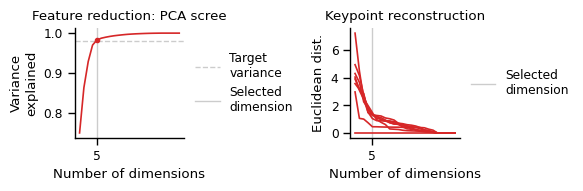

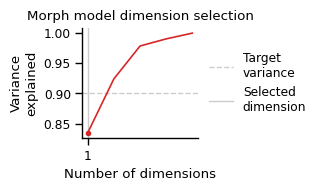

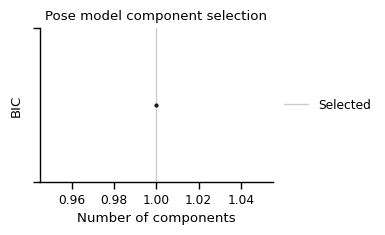

PosixPath('../projects/unit-test/in-domain-morph/plots/pose_calibration.pdf')

In [46]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [47]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan-pl1", {
    'morph.dist_var': [1e-1, 1e1, 1e6]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan-pl1", return_session_inv=True)

In [48]:
scans.run_scan(project, "morph-prior-scan-pl1", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/in-domain-morph/models/morph-prior-scan-pl1_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:1 -> 0.0005
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 38034.54296875
INFO:root:Step 20 : loss = 34611.2578125
INFO:root:Step 40 : loss = 34304.390625
INFO:root:Step 60 : loss = 34297.88671875
INFO:root:Step 80 : loss = 34297.89453125
INFO:root:Step 100 : loss = 34297.88671875
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/in-domain-morph/models/morph-prior-scan-pl1_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:1 -> 0.0005
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 33836.34375
INFO:root:Step 20 : loss = 33241.21875
INFO:r

##### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan-pl1_0
- reports


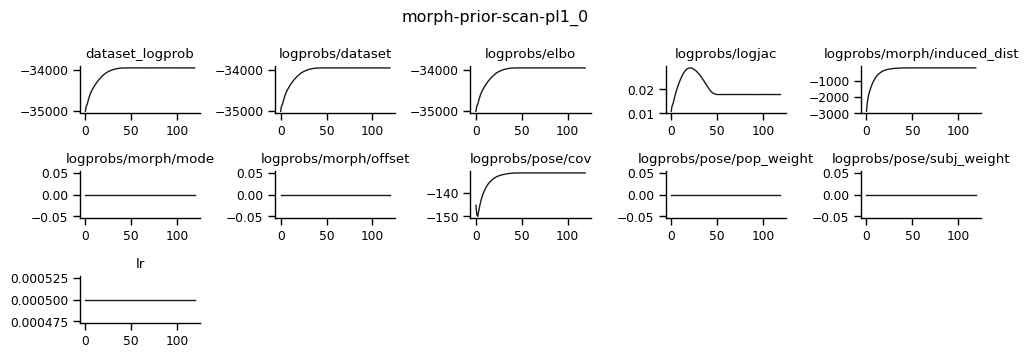

100%|██████████| 120/120 [00:00<00:00, 4425.62it/s]


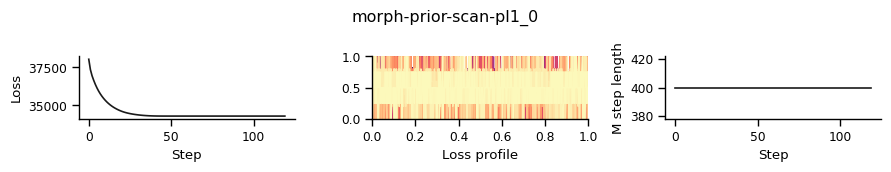

- morph


100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


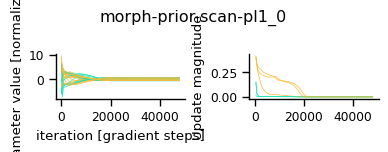

- gmm


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


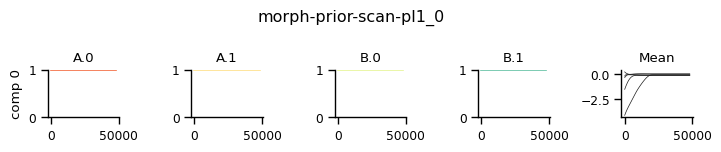

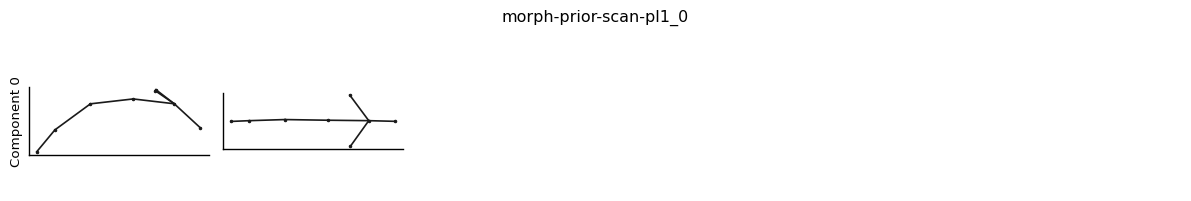

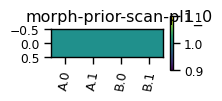

 33%|███▎      | 1/3 [00:02<00:05,  2.76s/it]

Plotting morph-prior-scan-pl1_1
- reports


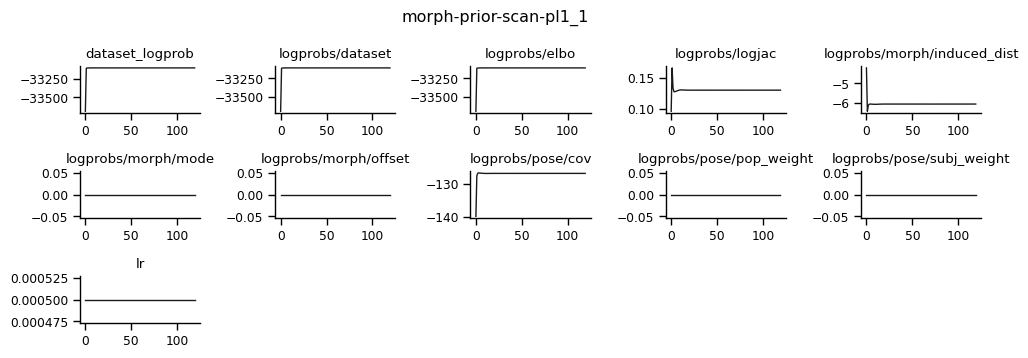

100%|██████████| 120/120 [00:00<00:00, 7188.69it/s]


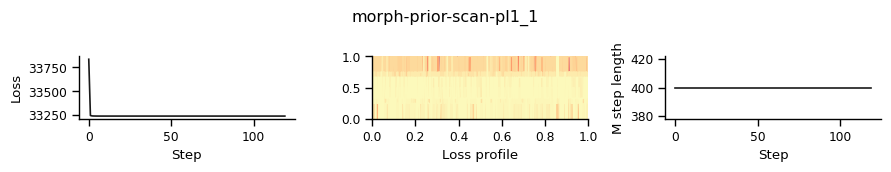

- morph


100%|██████████| 4/4 [00:00<00:00, 73.09it/s]


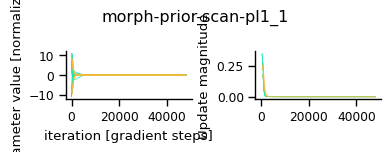

- gmm


100%|██████████| 1/1 [00:00<00:00, 54.80it/s]


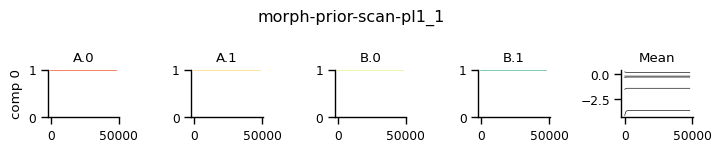

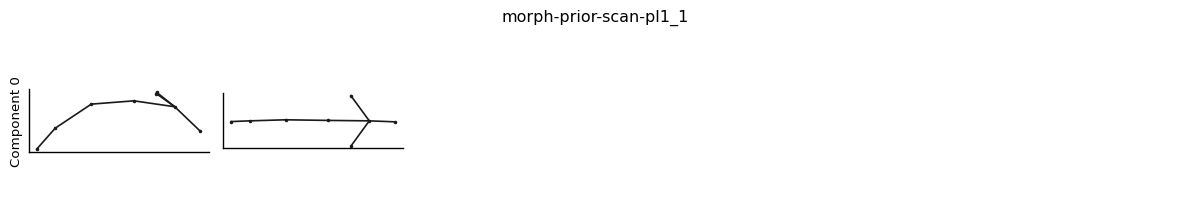

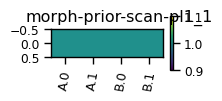

 67%|██████▋   | 2/3 [00:04<00:02,  2.11s/it]

Plotting morph-prior-scan-pl1_2
- reports


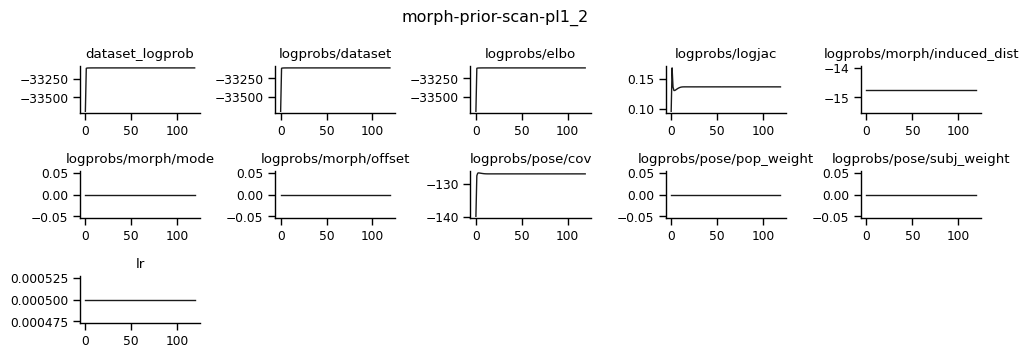

100%|██████████| 120/120 [00:00<00:00, 7076.80it/s]


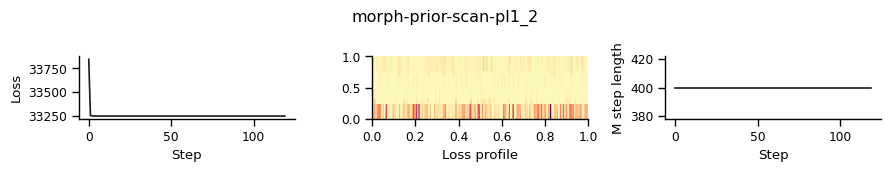

- morph


100%|██████████| 4/4 [00:00<00:00, 76.19it/s]


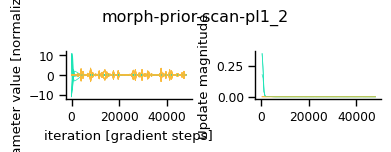

- gmm


100%|██████████| 1/1 [00:00<00:00, 26.55it/s]


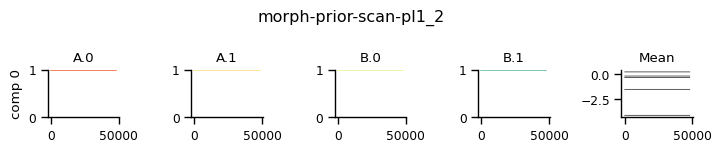

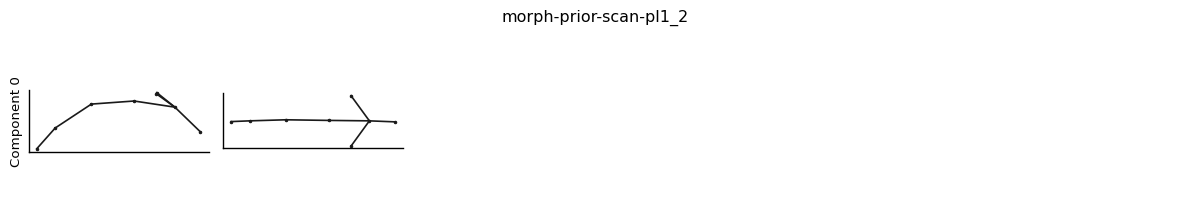

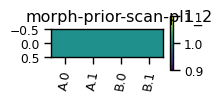

100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


In [49]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

##### Dataset specific results

###### 1
Dataset visualization

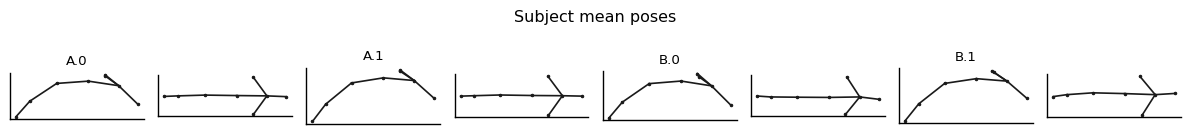

In [50]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

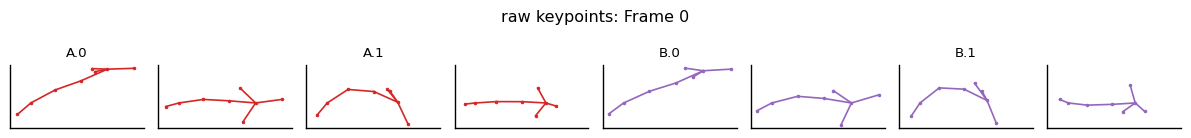

In [51]:
fig, ax = plt.subplots(1, 8, figsize=(12, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
for i, sess in enumerate(scan_dataset.sessions):
    root_sess = sess.split('.')[0]
    viz.util.plot_mouse_views(
        ax[2*i:2*(i+1)],
        inflated.get_session(sess)[0],
        arms, color = session_pal[root_sess], label=root_sess,
    )
    ax[2*i].set_title(sess)
fig.suptitle(f"raw keypoints: Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 2

PC respect validation (requires project calibration)


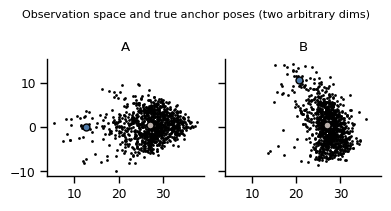

In [52]:
cfg = config.load_model_config(project.base_model_config())
anchors_2d = anchor_keypoints(
    true_params, {}, magnitudes=90, _inflate = lambda x: x
)
anchors_2d = anchors_2d.reshape(*(anchors_2d.shape[:2] + (len(use_keypts), 3)))
keypoints_2d = {s: k[:, [0, 1], [0, 1], None] for s, k in dataset_keypoints.items()}
anchors_2d = anchors_2d[:, :, [0, 1], [0, 1]]

fig, ax = plot_dataset_2d(["A", "B"], 0, keypoints_2d, None)
plot_anchors_2d(ax, None, [true_body_ids[s] for s in "AB"], anchors=anchors_2d)
fig.suptitle("Observation space and true anchor poses (two arbitrary dims)", fontsize=8)
plotter.finalize(fig, None)

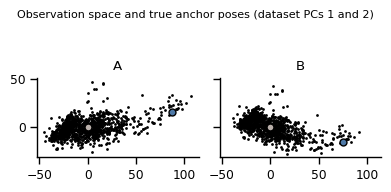

In [53]:
cfg = config.load_model_config(project.base_model_config())
dataset_pcs = CenteredPCA(cfg["features"]["calibration_data"]["center"], cfg["features"]["calibration_data"]["pcs"])
_reduce = lambda x: dataset_pcs.coords(x.reshape(x.shape[:-1] + (-1,))).reshape(x.shape)
anchors_2d = anchor_keypoints(
    true_params, {}, magnitudes=90, _inflate = lambda x: x
)
keypoints_2d = {s: _reduce(k.reshape(k.shape[0], -1))[:, [0, 1], None] for s, k in dataset_keypoints.items()}
anchors_2d = _reduce(anchors_2d)[..., [0, 1]]

fig, ax = plot_dataset_2d(["A", "B"], 0, keypoints_2d, None)
# fig, ax = plt.subplots(1, 2, figsize = (4, 2), sharex=True, sharey=True)
plot_anchors_2d(ax, None, [true_body_ids[s] for s in "AB"], anchors=anchors_2d)
fig.suptitle("Observation space and true anchor poses (dataset PCs 1 and 2)", fontsize=8)
plotter.finalize(fig, None)

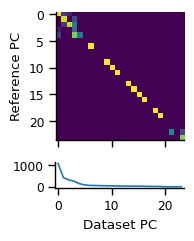

In [54]:
# Validate PCs
# PCs of reference session (A)
ref_pcs = fit_with_center(
    dataset_keypoints["A"].reshape(dataset_keypoints["A"].shape[0], -1)
)._pcadata

# PCs of full dataset
dataset_pcs = cfg["features"]["calibration_data"]["pcs"]
# _features = [k.reshape(k.shape[0], -1) for k in dataset_keypoints.values()]
# dataset_pcs = fit_with_center(
#     np.concatenate(_features, axis=0)
# )._pcadata

# shape: (ref_pc, dataset_pc)
pc_cos = (
    ref_pcs.pcs()[:, None]
    * dataset_pcs.pcs()[None]
).sum(axis=-1)

# plot cosine similarity between PC sets
fig, ax = plt.subplots(2, 1, figsize=(2,2.5), height_ratios=[5, 1], sharex=True)
_ = ax[0].imshow(pc_cos, vmin=0, vmax=1)
ax[1].plot(dataset_pcs.s)
ax[1].set_xlabel('Dataset PC')
ax[0].set_ylabel('Reference PC')
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

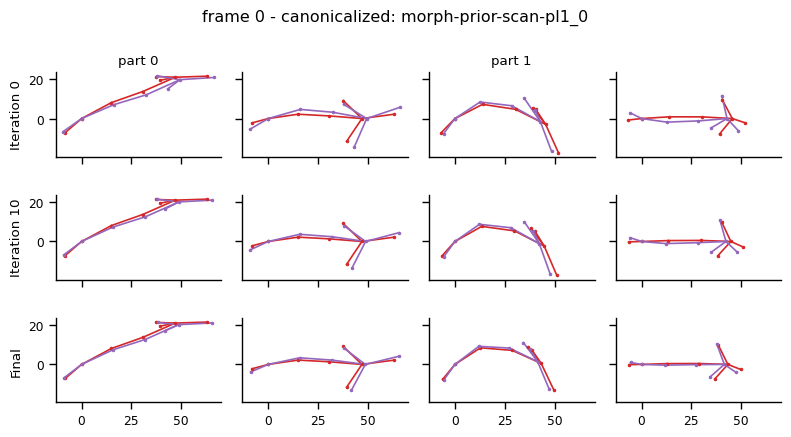

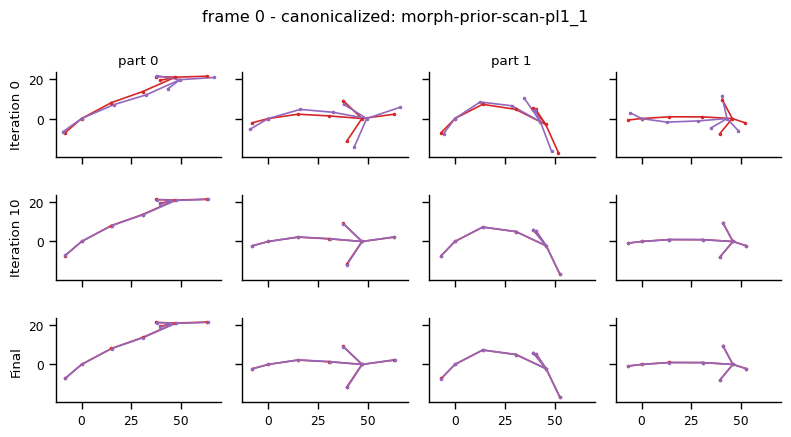

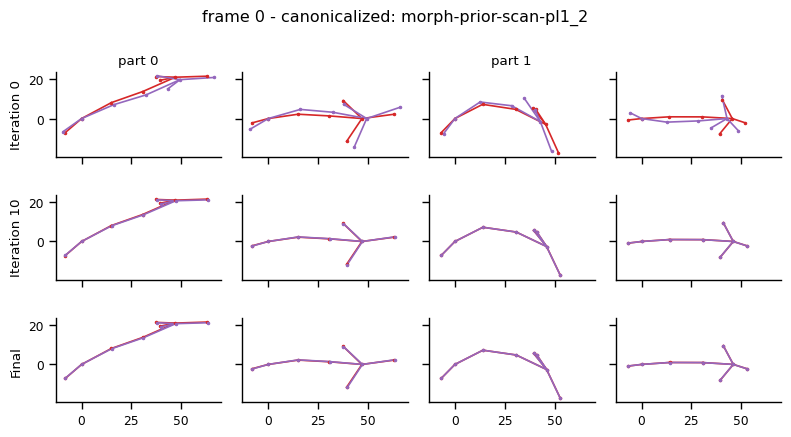

In [55]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in "AB":
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


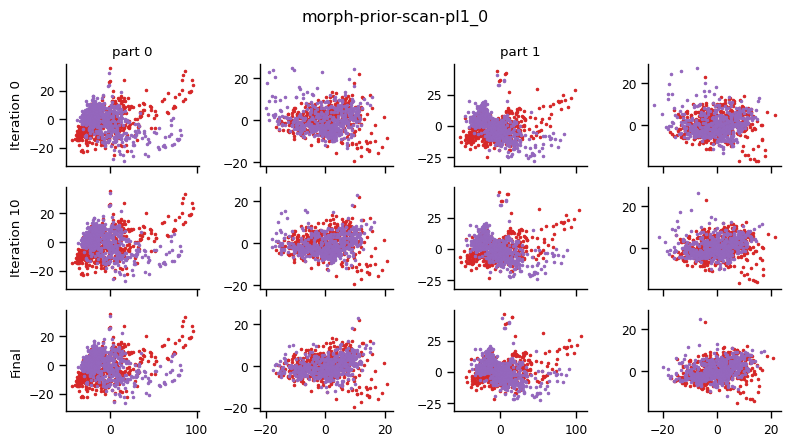

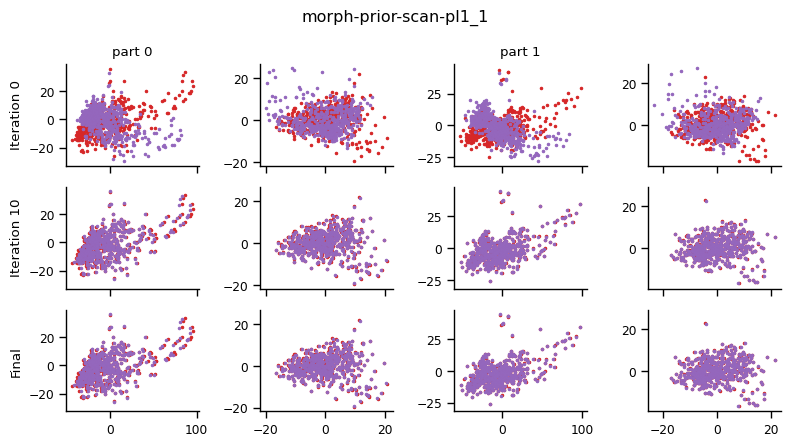

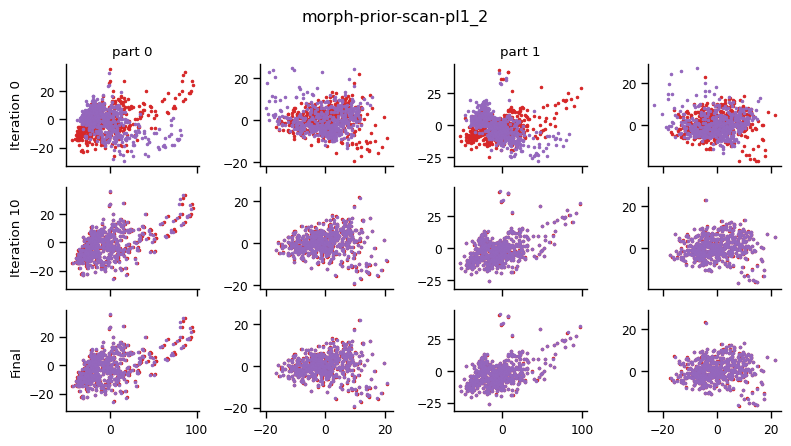

In [56]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    session_pal = dict(zip("AB", [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex='col', sharey = 'col')
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in "AB":
                sess = f"{root_sess}.{part}"
                
                ax[row, 2 * col].scatter(
                    *canonicalized.get_session(sess)[:, [0, 1]].T,
                    color = session_pal[root_sess],
                    label=root_sess,
                    s = 3,
                )
                ax[row, 2 * col + 1].scatter(
                    *canonicalized.get_session(sess)[:, [2, 3]].T,
                    color = session_pal[root_sess],
                    label=root_sess,
                    s = 3,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(model_name)
    plotter.finalize(fig, None)

## Out of domain morph (bone length scaling)

Data from `3wk_m0` with a copy scaled to bone lengths of the 52-week cohort.
There is no ground truth here, since bone length scaling is high rank, but we
are looking for good performance with a high number of anchor poses. Since there
is no behavior variation, we have no fear of using too many components.

To simplify fitting:
- 1 GMM component

##### Dataset generation

In [29]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "individual" / f"{base}wk_m0-to-52wk.yaml"
scale_dict = blscale_dir / "scale-dicts" / "cohort-wise" / f"{base}wk-to-all_ntt-norm.yaml"

# scale_dict = random_scale_dict('3wk_52bod_m0')

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')

# make a farse dataset
# dataset_keypoints['3wk_52bod_m0'] = dataset_keypoints['3wk_3bod_m0']

Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 339.34it/s]

Sessions: ['3wk_3bod_m0', '3wk_52bod_m0']


In [30]:
# Create base project config to override

project_dir = Path('../projects/unit-test/bl-3wk-to-52')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=1000,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [31]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["fit"]["n_steps"] = 120
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

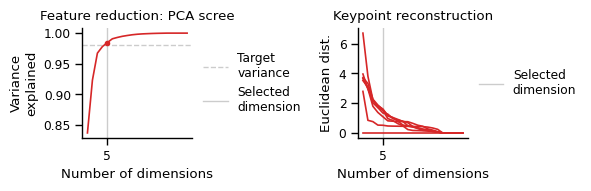

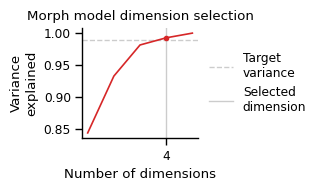

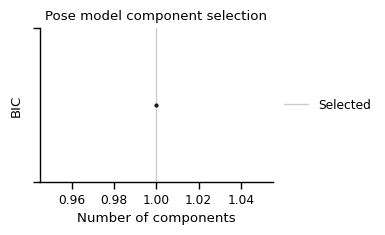

PosixPath('../projects/unit-test/bl-3wk-to-52/plots/pose_calibration.pdf')

In [32]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [67]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 1e1, 1e6],
    'fit.em.learning_rate': [1e-1, 1e-2, 1e-2]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [68]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:0.1 -> 5e-05
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 35589.5625
INFO:root:Step 20 : loss = 34865.0859375
INFO:root:Step 40 : loss = 34271.1015625
INFO:root:Step 60 : loss = 33822.671875
INFO:root:Step 80 : loss = 33507.0234375
INFO:root:Step 100 : loss = 33303.765625
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/models/morph-prior-scan_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:0.01 -> 5e-06
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 32813.37890625
INFO:root:Step 20 : loss = 32708.69140625
INFO:root:Step 40 :

##### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


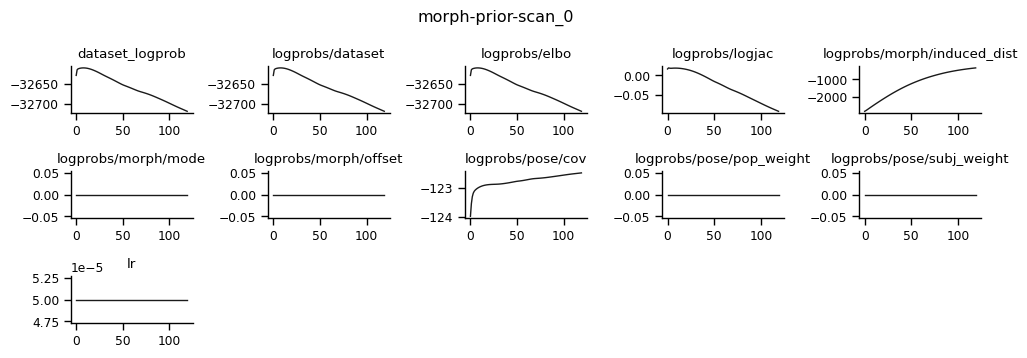

100%|██████████| 120/120 [00:00<00:00, 5417.13it/s]


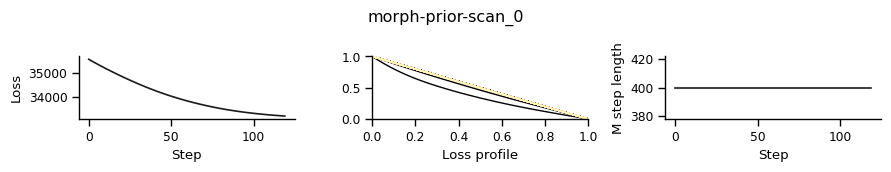

- morph


100%|██████████| 4/4 [00:00<00:00, 26.42it/s]


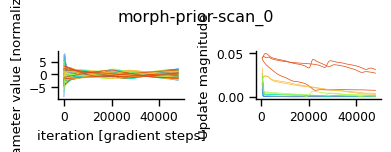

- gmm


100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


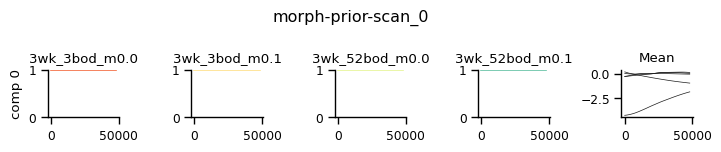

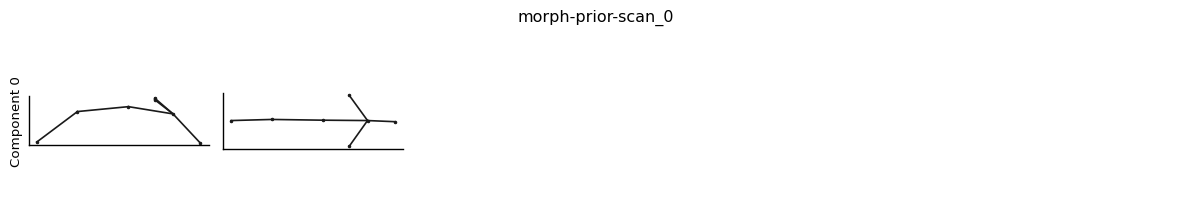

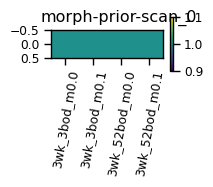

 33%|███▎      | 1/3 [00:01<00:03,  1.96s/it]

Plotting morph-prior-scan_1
- reports


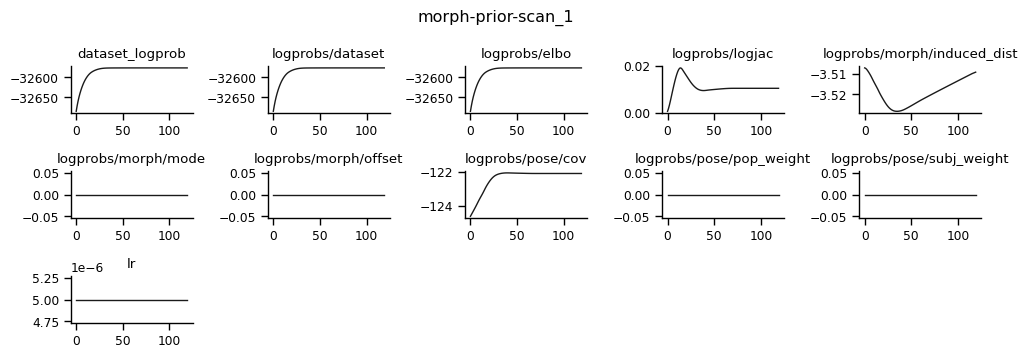

100%|██████████| 120/120 [00:00<00:00, 5948.24it/s]


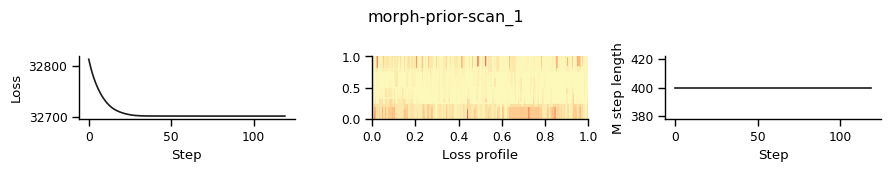

- morph


100%|██████████| 4/4 [00:00<00:00, 29.55it/s]


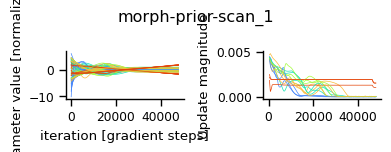

- gmm


100%|██████████| 1/1 [00:00<00:00, 37.46it/s]


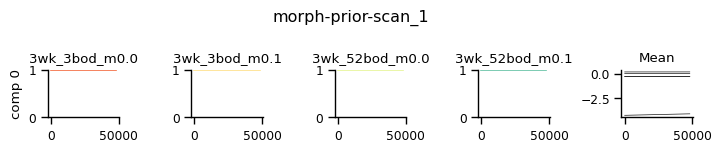

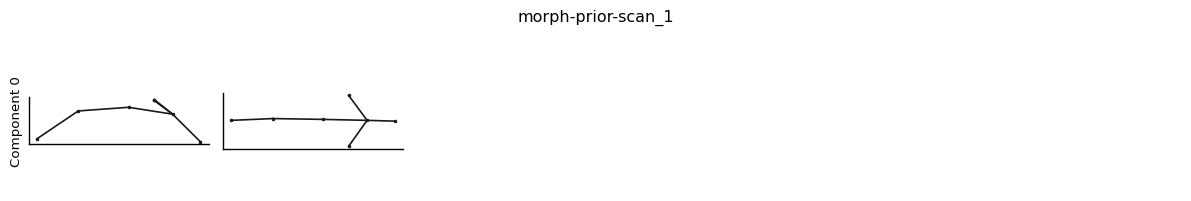

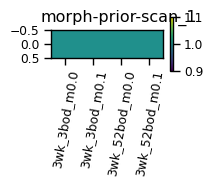

 67%|██████▋   | 2/3 [00:03<00:01,  1.81s/it]

Plotting morph-prior-scan_2
- reports


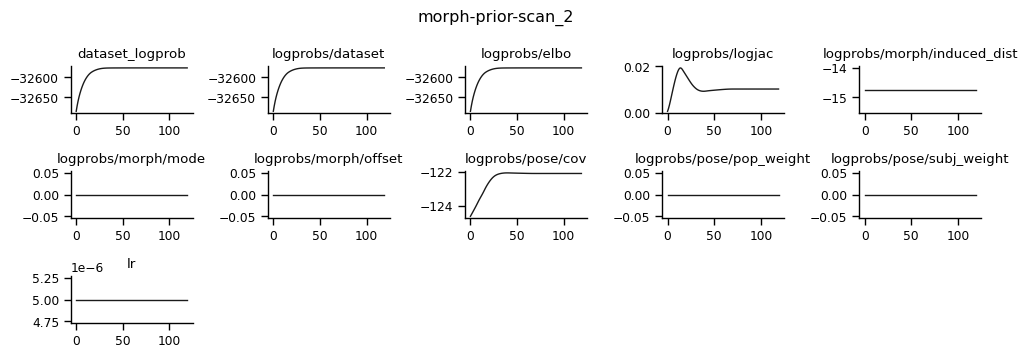

100%|██████████| 120/120 [00:00<00:00, 6272.48it/s]


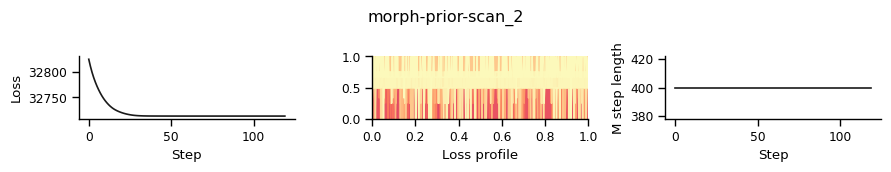

- morph


100%|██████████| 4/4 [00:00<00:00, 32.26it/s]


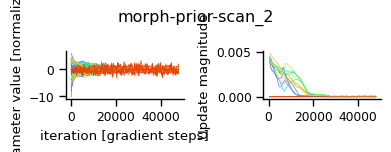

- gmm


100%|██████████| 1/1 [00:00<00:00, 46.77it/s]


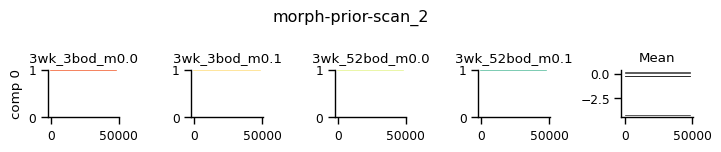

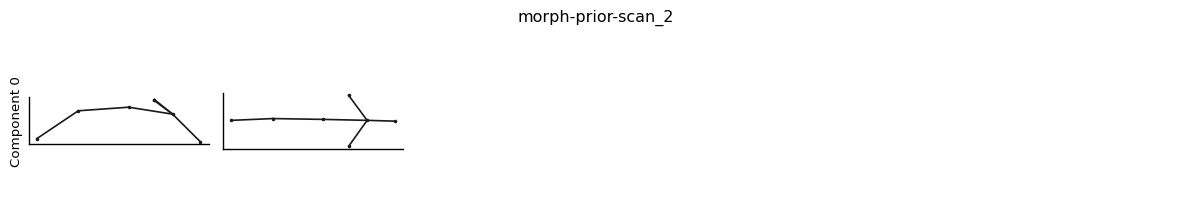

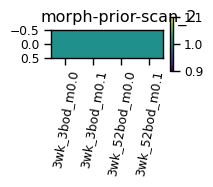

100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


In [69]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 18.87it/s]


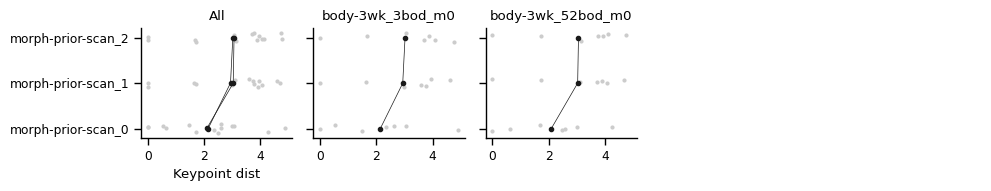

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [38]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

##### Dataset specific results

###### 1
Dataset visualization

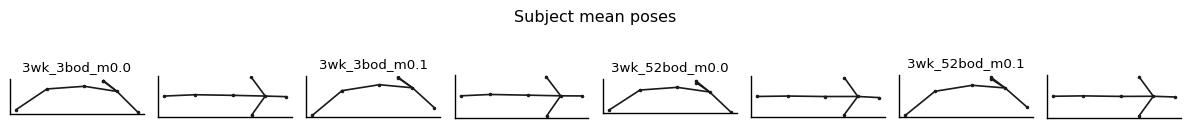

In [34]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

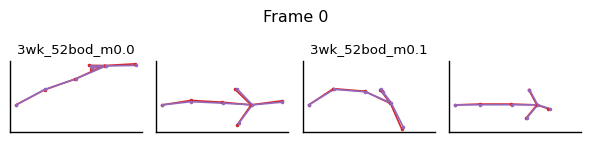

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 2

Observation space dataset scatterplots

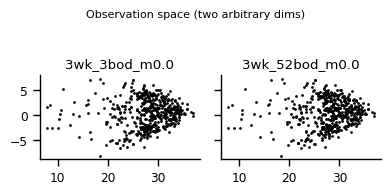

In [106]:
cfg = config.load_model_config(project.base_model_config())
inflated = features.inflate(scan_dataset, cfg["features"])
keypoints_2d = {s: inflated.get_session(s)[:, [0, 1], [0, 1], None] for s in inflated.sessions}

sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0']
fig, ax = plot_dataset_2d(sessions, 0, keypoints_2d, None)
fig.suptitle("Observation space (two arbitrary dims)", fontsize=8)
plotter.finalize(fig, None)

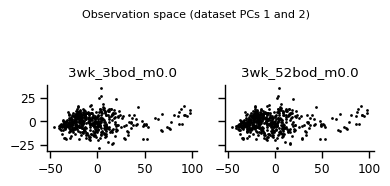

In [107]:
cfg = config.load_model_config(project.base_model_config())
dataset_pcs = CenteredPCA(cfg["features"]["calibration_data"]["center"], cfg["features"]["calibration_data"]["pcs"])
_reduce = lambda x: dataset_pcs.coords(x.reshape(x.shape[:-1] + (-1,))).reshape(x.shape)
inflated = features.inflate(scan_dataset, cfg["features"])
keypoints_2d = {s: inflated.get_session(s) for s in inflated.sessions}
keypoints_2d = {s: _reduce(k.reshape(k.shape[0], -1))[:, [0, 1], None] for s, k in keypoints_2d.items()}

sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0']
fig, ax = plot_dataset_2d(sessions, 0, keypoints_2d, None)
fig.suptitle("Observation space (dataset PCs 1 and 2)", fontsize=8)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

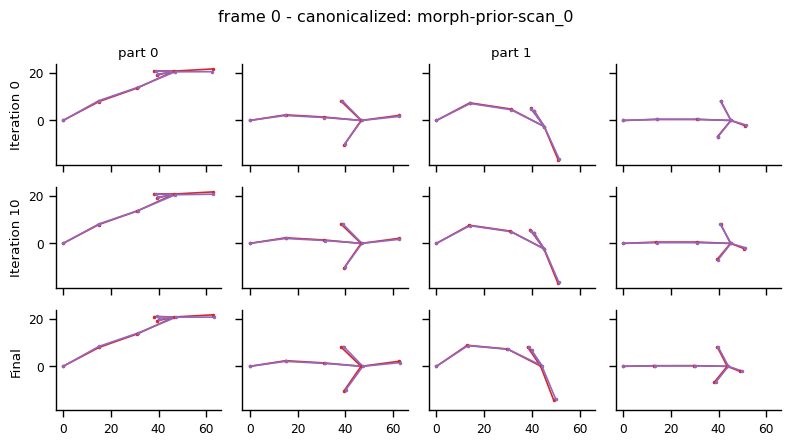

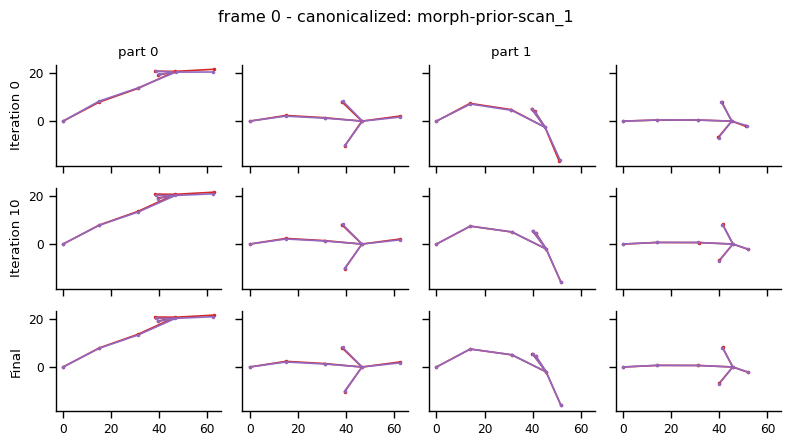

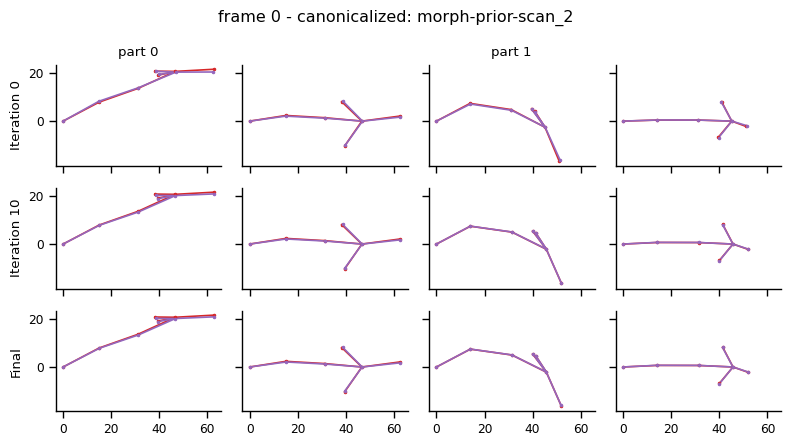

In [39]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in ['3wk_3bod_m0', '3wk_52bod_m0']:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

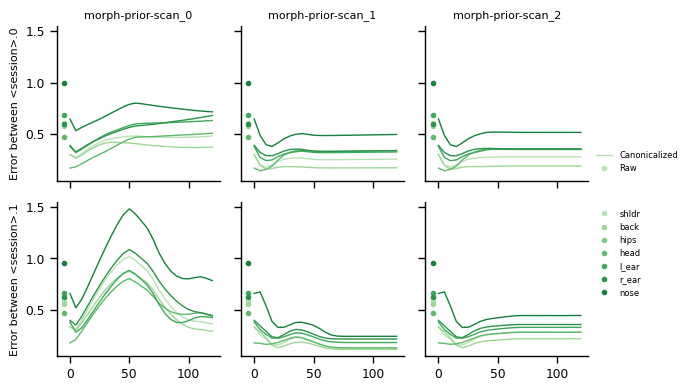

In [102]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

plot_iters = list(range(0, 120, 5)) + ['final']
parts = "01"

fig, ax = plt.subplots(len(parts), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)
_x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

base_errs = [[] for _ in range(len(parts))]
inflated = features.inflate(scan_dataset, cfg['features'])
for i_part, part in enumerate(parts):
    base_errs[i_part] = model_util.reconst_errs(
        inflated.get_session(f"3wk_3bod_m0.{part}"),
        inflated.get_session(f"3wk_52bod_m0.{part}"),
        average=False,
    ).mean(axis=0)
base_errs = np.array(base_errs)

for i_mod, model_name in enumerate(models):
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])

    errs = [[] for _ in range(len(parts))]
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for i_part, part in enumerate(parts):
            errs[i_part].append(model_util.reconst_errs(
                inflated.get_session(f"3wk_3bod_m0.{part}"),
                inflated.get_session(f"3wk_52bod_m0.{part}"),
                average=False,
            ).mean(axis=0))
    errs = np.array(errs)

    for i_part, part in enumerate(parts):
        for i_kp in range(errs.shape[-1]):
            if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                continue
            ax[i_part, i_mod].plot(_x, errs[i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_part, i_mod].plot([-_x[1]], [base_errs[i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_part, 0].set_ylabel(f"Error between <session>.{part}", fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
    for i_kp in range(errs.shape[-1])
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)


## Out of domain morph II (no incoming nose to tail normalization)

Same as the above project, but without rigid scale normalization on the incoming
data. Since scale normalization is performed during alignment, these results
should be identical to those from the above test.

##### Dataset generation

In [104]:
blscale_dir = Path('/Users/kaifox/projects/mph/data_explore/testsets/blscale-dicts')
data_dir = Path("/Users/kaifox/projects/mph/data_explore/data")

base = '3'
source_dict = blscale_dir / "source-dicts" / "individual" / f"{base}wk_m0-to-52wk.yaml"
scale_dict = blscale_dir / "scale-dicts" / "all-to-named-age_unnormed.yaml"

# scale_dict = random_scale_dict('3wk_52bod_m0')

project_config_kws, dataset_keypoints, scales = blscale_dataset(source_dict, scale_dict, data_dir, ref_session='3wk_3bod_m0')

# make a farse dataset
# dataset_keypoints['3wk_52bod_m0'] = dataset_keypoints['3wk_3bod_m0']

Loading keypoints: 100%|█████████████████| 1/1 [00:00<00:00, 290.50it/s]

Sessions: ['3wk_3bod_m0', '3wk_52bod_m0']


In [105]:
# Create base project config to override

project_dir = Path('../projects/unit-test/bl-3wk-to-52-unnormed')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=1000,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [119]:
# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["fit"]["n_steps"] = 120
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

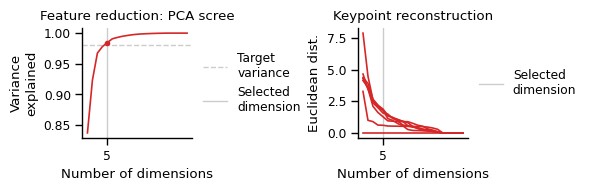

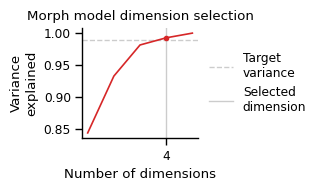

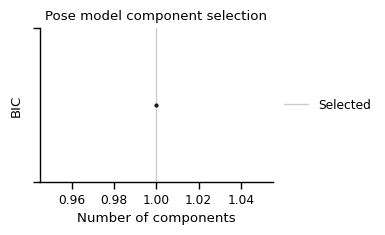

PosixPath('../projects/unit-test/bl-3wk-to-52/plots/pose_calibration.pdf')

In [120]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [121]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 1e1, 1e6],
    'fit.em.learning_rate': [1e-1, 1e-2, 1e-2]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [122]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:0.1 -> 5e-05
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 39805.80078125
INFO:root:Step 20 : loss = 38639.85546875
INFO:root:Step 40 : loss = 37612.125
INFO:root:Step 60 : loss = 36773.45703125
INFO:root:Step 80 : loss = 36139.0859375
INFO:root:Step 100 : loss = 35671.7578125
INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/models/morph-prior-scan_1
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 500 frames
INFO:root:Adjusting learning rate:0.01 -> 5e-06
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 34437.7421875
INFO:root:Step 20 : loss = 34333.23046875
INFO:root:Step 4

##### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


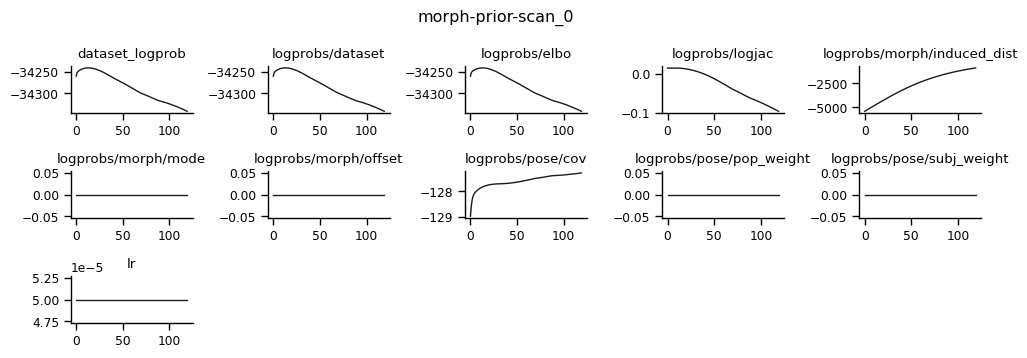

100%|██████████| 120/120 [00:00<00:00, 1119.45it/s]


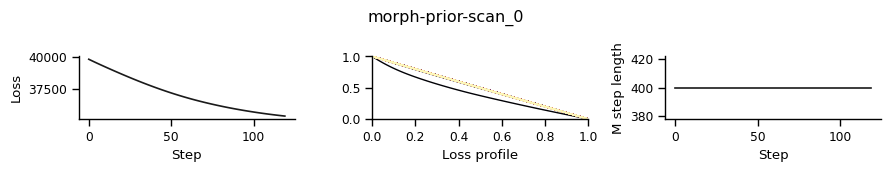

- morph


100%|██████████| 4/4 [00:00<00:00, 30.55it/s]


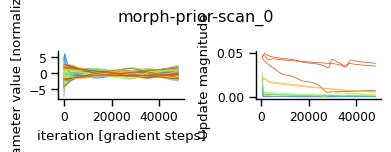

- gmm


100%|██████████| 1/1 [00:00<00:00, 48.87it/s]


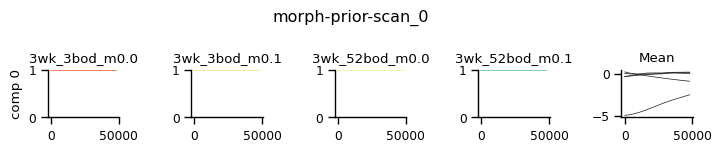

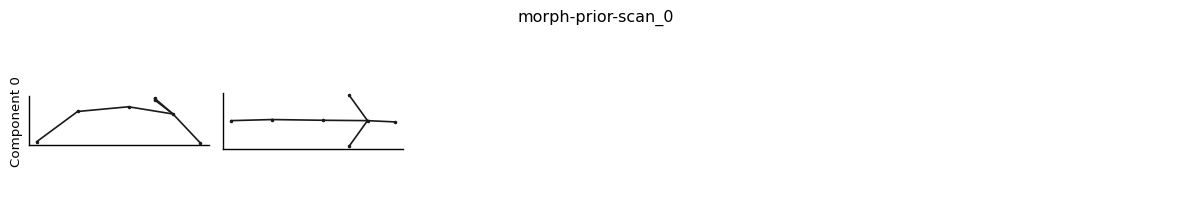

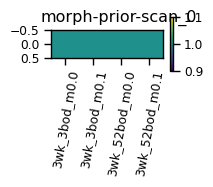

 33%|███▎      | 1/3 [00:02<00:04,  2.48s/it]

Plotting morph-prior-scan_1
- reports


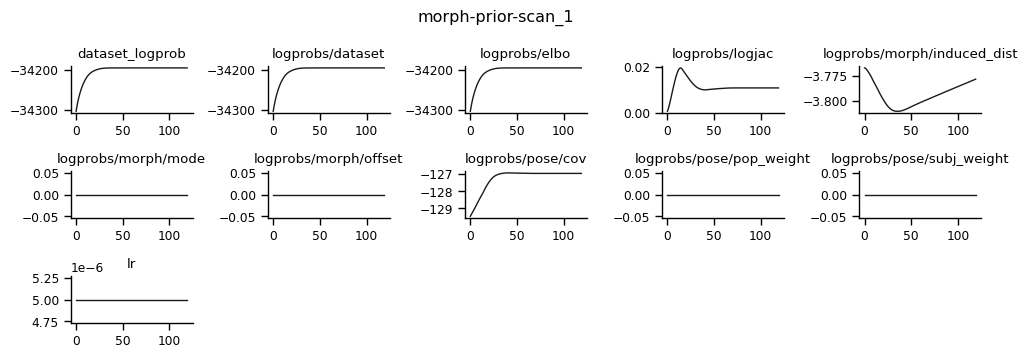

100%|██████████| 120/120 [00:00<00:00, 4921.64it/s]


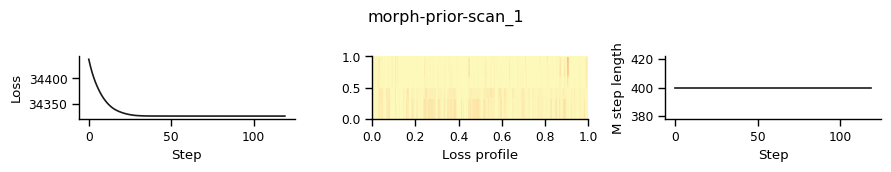

- morph


100%|██████████| 4/4 [00:00<00:00, 28.91it/s]


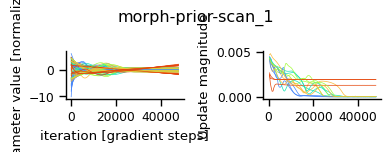

- gmm


100%|██████████| 1/1 [00:00<00:00, 35.56it/s]


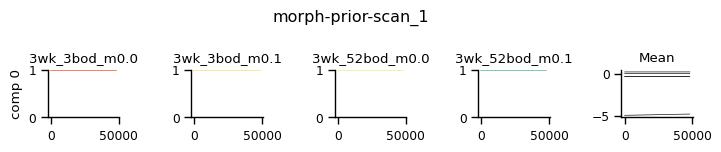

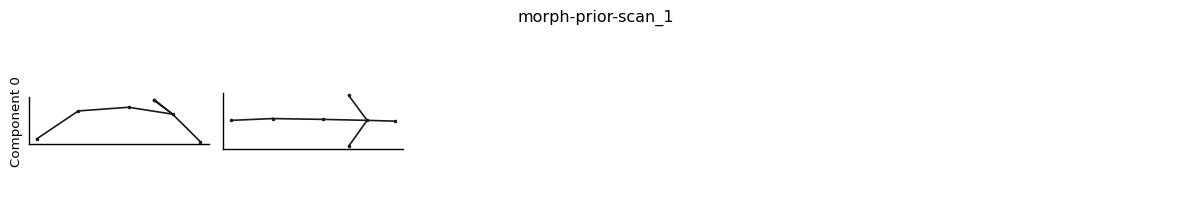

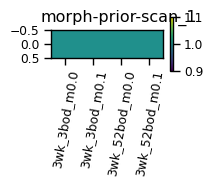

 67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

Plotting morph-prior-scan_2
- reports


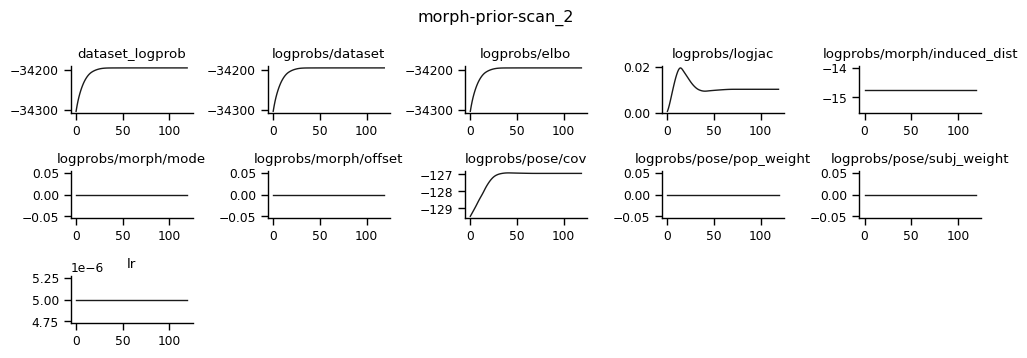

100%|██████████| 120/120 [00:00<00:00, 6530.22it/s]


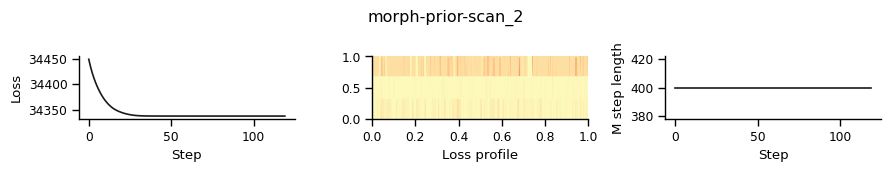

- morph


100%|██████████| 4/4 [00:00<00:00, 22.53it/s]


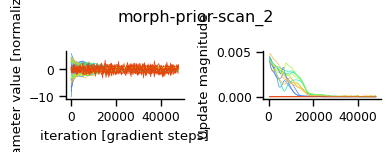

- gmm


100%|██████████| 1/1 [00:00<00:00, 49.37it/s]


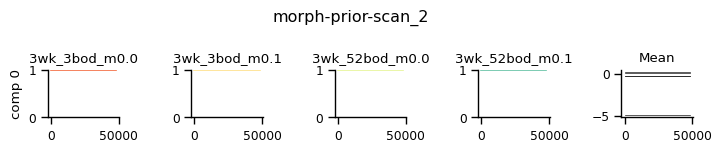

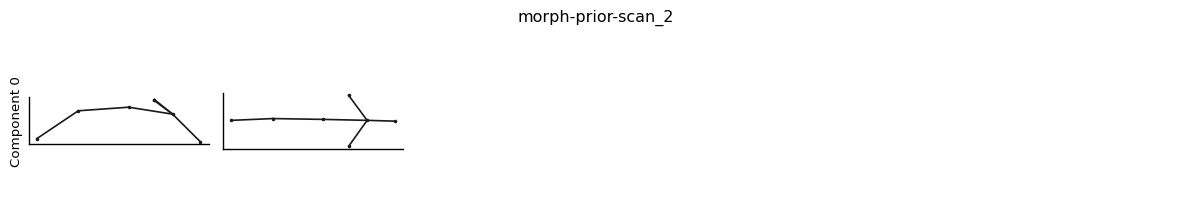

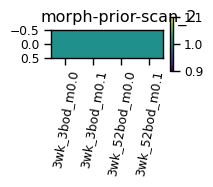

100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


In [123]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(1.5, 1.5), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, normalize=False, ax_size=(1.5, 1.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 18.87it/s]


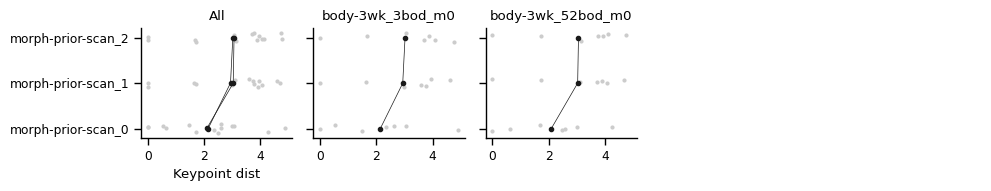

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/bl-3wk-to-52/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [ ]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

##### Dataset specific results

###### 1
Dataset visualization

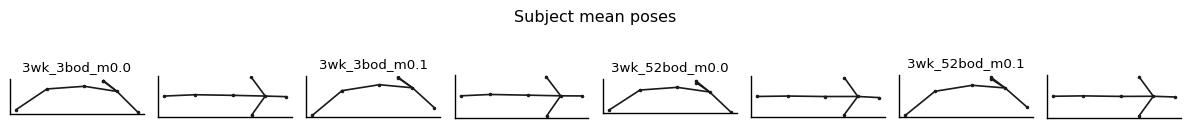

In [109]:
# plot dataset before any morphing
cfg = config.load_project_config(project.main_config())
fig = viz.general.session_means(cfg, features.inflate(scan_dataset, cfg["features"]))
plotter.finalize(fig, None)

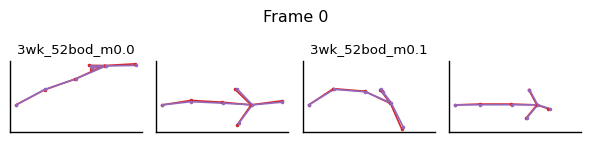

In [110]:
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), sharex=True, sharey = True)
cfg = config.load_project_config(project.main_config())
session_pal = dict(zip([3, 52], [colors.C[0], colors.C[1]]))
inflated = features.inflate(scan_dataset, cfg["features"])
arms = Armature.from_config(cfg["dataset"])
sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0', '3wk_3bod_m0.1', '3wk_52bod_m0.1']
cols = [0, 0, 2, 2]
for i, (sess, col) in enumerate(zip(sessions, cols)):
    sess_body = int(re.search(r"(\d+)bod", sess).group(1))
    viz.util.plot_mouse_views(
        ax[(col):col+2],
        inflated.get_session(sess)[0],
        arms, color = session_pal[sess_body], label=sess_body,
    )
    ax[(col)].set_title(sess)
fig.suptitle(f"Frame 0")
viz.util.axes_off(ax)
plotter.finalize(fig, None)

###### 2

Observation space dataset scatterplots

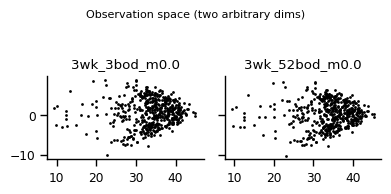

In [117]:
cfg = config.load_model_config(project.base_model_config())
inflated = features.inflate(scan_dataset, cfg["features"])
keypoints_2d = {s: inflated.get_session(s)[:, [0, 1], [0, 1], None] for s in inflated.sessions}

sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0']
fig, ax = plot_dataset_2d(sessions, 0, keypoints_2d, None)
fig.suptitle("Observation space (two arbitrary dims)", fontsize=8)
plotter.finalize(fig, None)

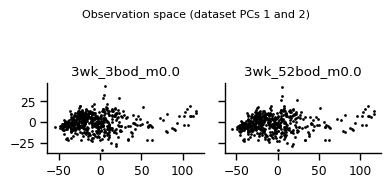

In [118]:
cfg = config.load_model_config(project.base_model_config())
dataset_pcs = CenteredPCA(cfg["features"]["calibration_data"]["center"], cfg["features"]["calibration_data"]["pcs"])
_reduce = lambda x: dataset_pcs.coords(x.reshape(x.shape[:-1] + (-1,))).reshape(x.shape)
inflated = features.inflate(scan_dataset, cfg["features"])
keypoints_2d = {s: inflated.get_session(s) for s in inflated.sessions}
keypoints_2d = {s: _reduce(k.reshape(k.shape[0], -1))[:, [0, 1], None] for s, k in keypoints_2d.items()}

sessions = ['3wk_3bod_m0.0', '3wk_52bod_m0.0']
fig, ax = plot_dataset_2d(sessions, 0, keypoints_2d, None)
fig.suptitle("Observation space (dataset PCs 1 and 2)", fontsize=8)
plotter.finalize(fig, None)

###### 3
Anchor poses and canonical spaces

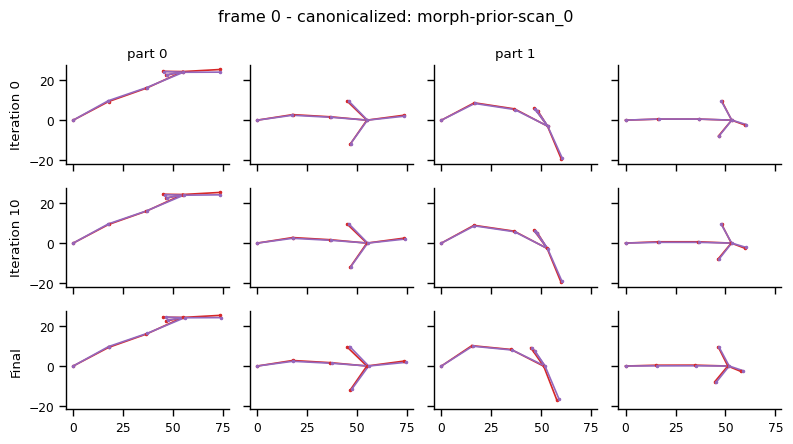

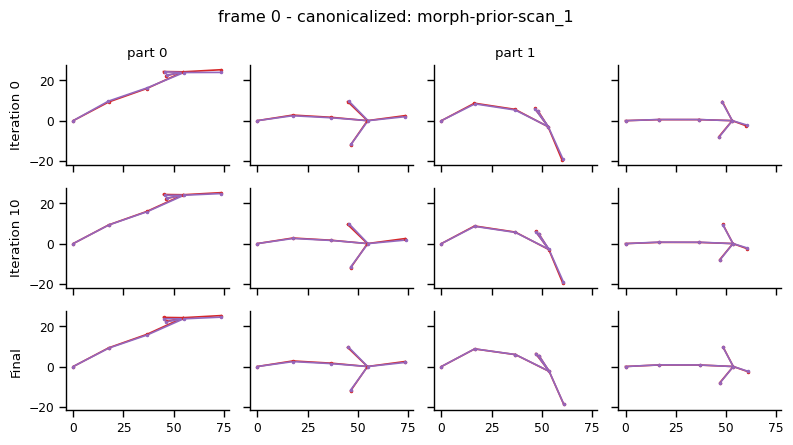

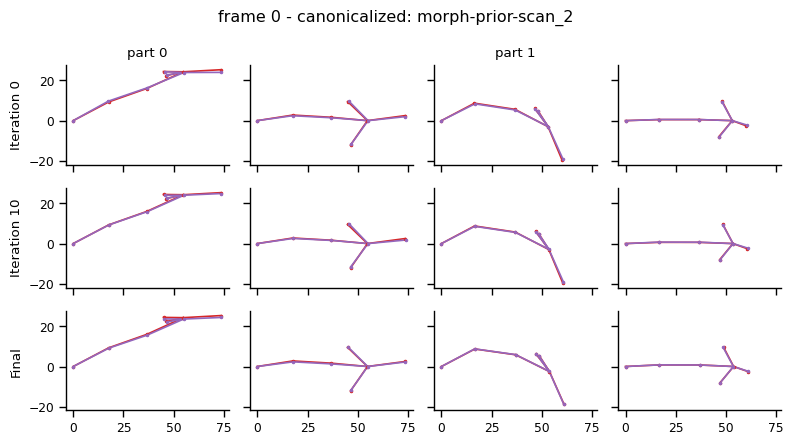

In [124]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should match
# since they only vary by the random morph

plot_iters = [0, 10, 'final']
for model_name in models:
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])
    fig, ax = plt.subplots(len(plot_iters), 4, figsize=(8, 1.5 * len(plot_iters)), sharex=True, sharey = True)
    if len(plot_iters) == 1:
        ax = ax[None]

    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
            ax[row, 0].set_ylabel(f"Iteration {plot_iter}")
        else:
            step_params = ckpt["params"]
            ax[row, 0].set_ylabel("Final")
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])


        for col, part in enumerate("01"):
            for root_sess in ['3wk_3bod_m0', '3wk_52bod_m0']:
                sess = f"{root_sess}.{part}"
                viz.util.plot_mouse_views(
                    ax[row, 2 * col : 2 * col + 2],
                    inflated.get_session(sess)[0],
                    arms, color = session_pal[root_sess], label=root_sess,
                )
            if row == 0:
                ax[row, 2 * col].set_title(f"part {part}")

    fig.suptitle(f"frame 0 - canonicalized: {model_name}")
    plotter.finalize(fig, None)


###### 4

Framewise keypoint error over training

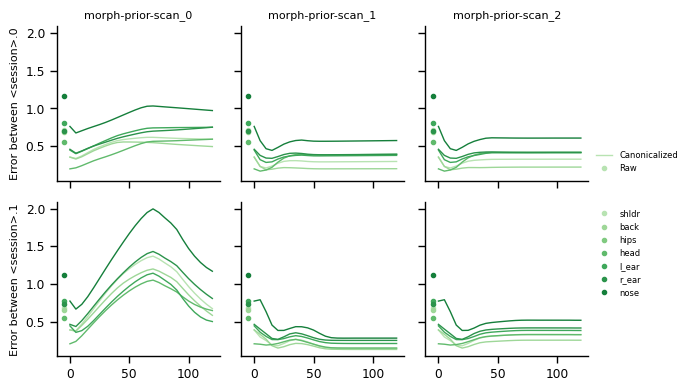

In [126]:
# once canonicalizeed, frames/means of sessions A.0 and B.0 should (approximately) match
# since they only vary by the bone scaling morph

n_kpt = 7
kp_colors = Colormap('greens')(np.linspace(0.3, 0.8, n_kpt))

plot_iters = list(range(0, 120, 5)) + ['final']
parts = "01"

fig, ax = plt.subplots(len(parts), len(models), figsize=(2 * len(models) + 1, 2 * len(parts)), sharex=True, sharey = True)
_x = [(x_ if isinstance(x_, int) else len(ckpt["meta"]["loss"])) for x_ in plot_iters]

base_errs = [[] for _ in range(len(parts))]
inflated = features.inflate(scan_dataset, cfg['features'])
for i_part, part in enumerate(parts):
    base_errs[i_part] = model_util.reconst_errs(
        inflated.get_session(f"3wk_3bod_m0.{part}"),
        inflated.get_session(f"3wk_52bod_m0.{part}"),
        average=False,
    ).mean(axis=0)
base_errs = np.array(base_errs)

for i_mod, model_name in enumerate(models):
    sessions = ['3wk_3bod_m0', '3wk_52bod_m0']
    session_pal = dict(zip(sessions, [colors.C[0], colors.C[1]]))

    ckpt = methods.load_fit(project.model(model_name))
    cfg = ckpt["config"]
    model = instantiation.get_model(cfg)
    arms = Armature.from_config(cfg["dataset"])

    errs = [[] for _ in range(len(parts))]
    for row, plot_iter in enumerate(plot_iters):
        if isinstance(plot_iter, int):
            step_params = scans.select_param_step(
                model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iter
            )
        else:
            step_params = ckpt["params"]
        canonicalized = model_util.apply_bodies(
            model.morph,
            step_params.morph,
            scan_dataset,
            {s: scan_dataset.session_body_name(scan_dataset.ref_session) for s in scan_dataset.sessions},
        )
        # canonicalized = scan_dataset
        inflated = features.inflate(canonicalized, cfg['features'])

        for i_part, part in enumerate(parts):
            errs[i_part].append(model_util.reconst_errs(
                inflated.get_session(f"3wk_3bod_m0.{part}"),
                inflated.get_session(f"3wk_52bod_m0.{part}"),
                average=False,
            ).mean(axis=0))
    errs = np.array(errs)

    for i_part, part in enumerate(parts):
        for i_kp in range(errs.shape[-1]):
            if cfg["dataset"]["use_keypoints"][i_kp] == 'hips':
                continue
            ax[i_part, i_mod].plot(_x, errs[i_part, :, i_kp], color=kp_colors[i_kp], lw = 1, ms = 0, label = "Canonicalized")
            ax[i_part, i_mod].plot([-_x[1]], [base_errs[i_part, i_kp]], 'o', color=kp_colors[i_kp], lw = 0, ms = 3, label = "Raw")
        ax[0, i_mod].set_title(model_name, fontsize = 8)
        ax[i_part, 0].set_ylabel(f"Error between <session>.{part}", fontsize = 8)

kp_artists = [
    ax[0, 1].plot([np.nan], [np.nan], 'o', color=kp_colors[i_kp], ms = 3, label = cfg["dataset"]["use_keypoints"][i_kp])[0]
    for i_kp in range(errs.shape[-1])
]
kp_handles, kp_labels = zip(*[[h, l] for h, l in zip(*ax[0, 1].get_legend_handles_labels()) if h in kp_artists])

ax[0, -1].legend(*viz.util.unique_handles(ax[0, -1]), loc = 'lower left', bbox_to_anchor=(1,0,), fontsize = 6, frameon=False)
ax[1, -1].legend(kp_handles, kp_labels, loc = 'upper left', bbox_to_anchor=(1,1), fontsize = 6, frameon=False)
plt.tight_layout()
plotter.finalize(fig, None)
